# Exploring Mocrobiology Cultures in the MIMIC IV data

In [1]:
import os
import pandas as pd

import psycopg2

In [2]:
# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'omop_cdm'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

## Top Organisms Tested

In [160]:
organismsQuery = """
select org_name, count(*) as cnt from mimiciv.microbiologyevents group by org_name order by cnt desc;
"""
organismsDf = pd.read_sql_query(organismsQuery, con)
organismsDf.iloc[:10, :]

,org_name,cnt
0,None,2064764
1,ESCHERICHIA COLI,470442
2,STAPH AUREUS COAG +,189442
3,KLEBSIELLA PNEUMONIAE,122392
4,PSEUDOMONAS AERUGINOSA,67225
5,PROTEUS MIRABILIS,54678
6,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",52420
7,ENTEROCOCCUS SP.,48369
8,CANCELLED,34056
9,YEAST,27698


## Top Antibiotics Tested

In [11]:
antibioticsQuery = """
select
ab_name, count(*) as cnt
from mimiciv.microbiologyevents
where org_name in (
	'ESCHERICHIA COLI',
	'STAPH AUREUS COAG +',
	'KLEBSIELLA PNEUMONIAE',
	'PSEUDOMONAS AERUGINOSA',
	'PROTEUS MIRABILIS',
	'STAPHYLOCOCCUS, COAGULASE NEGATIVE',
	'ENTEROCOCCUS SP.'
)
group by ab_name
order by cnt desc
;
"""
antibioticsDf = pd.read_sql_query(antibioticsQuery, con)
antibioticsDf

,ab_name,cnt
0,GENTAMICIN,89540
1,TRIMETHOPRIM/SULFA,75028
2,CIPROFLOXACIN,59926
3,CEFTAZIDIME,59689
4,TOBRAMYCIN,59683
5,MEROPENEM,59676
6,CEFEPIME,59584
7,AMPICILLIN,51673
8,PIPERACILLIN/TAZO,51596
9,AMPICILLIN/SULBACTAM,50731


## `ESCHERICHIA COLI`

In [12]:
ecoliQuery = """
with stg1 as(
	select
	ab_name,
	interpretation,
	count(*) as cnt
	from mimiciv.microbiologyevents
	where org_name = 'ESCHERICHIA COLI'
	group by ab_name, interpretation
	order by ab_name, interpretation desc
),
stg2 as(
	select
	ab_name,
	interpretation,
	cnt,
	sum(cnt) over (partition by ab_name) as total
	from
	stg1
)
select 
	ab_name,
	interpretation,
	cnt,
	round((cnt/total*100), 2) as pct
from
stg2
;
"""
ecoliDf = pd.read_sql_query(ecoliQuery, con)
ecoliDf

,ab_name,interpretation,cnt,pct
0,AMIKACIN,S,3005,98.46
1,AMIKACIN,R,40,1.31
2,AMIKACIN,I,7,0.23
3,AMPICILLIN,S,16779,47.00
4,AMPICILLIN,R,18503,51.83
5,AMPICILLIN,I,415,1.16
6,AMPICILLIN/SULBACTAM,S,21099,58.79
7,AMPICILLIN/SULBACTAM,R,8364,23.31
8,AMPICILLIN/SULBACTAM,I,6426,17.91
9,CEFAZOLIN,S,28293,78.85


## `STAPH AUREUS COAG +`

In [38]:
staph1Query = """
with stg1 as(
	select
	ab_name,
	interpretation,
	count(*) as cnt
	from mimiciv.microbiologyevents
	where org_name = 'STAPH AUREUS COAG +'
	group by ab_name, interpretation
	order by ab_name, interpretation desc
),
stg2 as(
	select
	ab_name,
	interpretation,
	cnt,
	sum(cnt) over (partition by ab_name) as total
	from
	stg1
)
select 
	ab_name,
	interpretation,
	cnt,
	round((cnt/total*100), 2) as pct
from
stg2
;
"""
staph1Df = pd.read_sql_query(staph1Query, con)
staph1Df

,ab_name,interpretation,cnt,pct
0,AMPICILLIN,S,10,71.43
1,AMPICILLIN,R,4,28.57
2,AMPICILLIN/SULBACTAM,S,1,100.00
3,CIPROFLOXACIN,S,42,53.16
4,CIPROFLOXACIN,R,35,44.30
5,CIPROFLOXACIN,I,2,2.53
6,CLINDAMYCIN,S,13439,64.22
7,CLINDAMYCIN,R,7467,35.68
8,CLINDAMYCIN,I,20,0.10
9,DAPTOMYCIN,S,539,99.81


## `KLEBSIELLA PNEUMONIAE`

In [17]:
kelbsQuery = """
with stg1 as(
	select
	ab_name,
	interpretation,
	count(*) as cnt
	from mimiciv.microbiologyevents
	where org_name = 'KLEBSIELLA PNEUMONIAE'
	group by ab_name, interpretation
	order by ab_name, interpretation desc
),
stg2 as(
	select
	ab_name,
	interpretation,
	cnt,
	sum(cnt) over (partition by ab_name) as total
	from
	stg1
)
select 
	ab_name,
	interpretation,
	cnt,
	round((cnt/total*100), 2) as pct
from
stg2
;
"""
kelbsDf = pd.read_sql_query(kelbsQuery, con)
kelbsDf

,ab_name,interpretation,cnt,pct
0,AMIKACIN,S,699,89.27
1,AMIKACIN,R,76,9.71
2,AMIKACIN,I,8,1.02
3,AMPICILLIN,S,1,10.00
4,AMPICILLIN,R,8,80.00
5,AMPICILLIN,I,1,10.00
6,AMPICILLIN/SULBACTAM,S,7659,74.93
7,AMPICILLIN/SULBACTAM,R,1994,19.51
8,AMPICILLIN/SULBACTAM,I,569,5.57
9,CEFAZOLIN,S,8358,81.79


## `PSEUDOMONAS AERUGINOSA`

In [18]:
pseudoQuery = """
with stg1 as(
	select
	ab_name,
	interpretation,
	count(*) as cnt
	from mimiciv.microbiologyevents
	where org_name = 'PSEUDOMONAS AERUGINOSA'
	group by ab_name, interpretation
	order by ab_name, interpretation desc
),
stg2 as(
	select
	ab_name,
	interpretation,
	cnt,
	sum(cnt) over (partition by ab_name) as total
	from
	stg1
)
select 
	ab_name,
	interpretation,
	cnt,
	round((cnt/total*100), 2) as pct
from
stg2
;
"""
pseudoDf = pd.read_sql_query(pseudoQuery, con)
pseudoDf

,ab_name,interpretation,cnt,pct
0,AMIKACIN,S,1020,86.59
1,AMIKACIN,R,77,6.54
2,AMIKACIN,I,81,6.88
3,AMPICILLIN,S,5,71.43
4,AMPICILLIN,R,2,28.57
5,AMPICILLIN/SULBACTAM,R,1,100.00
6,CEFAZOLIN,R,1,100.00
7,CEFEPIME,S,7154,79.92
8,CEFEPIME,R,772,8.62
9,CEFEPIME,I,1025,11.45


## `PROTEUS MIRABILIS`

In [16]:
proteusQuery = """
with stg1 as(
	select
	ab_name,
	interpretation,
	count(*) as cnt
	from mimiciv.microbiologyevents
	where org_name = 'PROTEUS MIRABILIS'
	group by ab_name, interpretation
	order by ab_name, interpretation desc
),
stg2 as(
	select
	ab_name,
	interpretation,
	cnt,
	sum(cnt) over (partition by ab_name) as total
	from
	stg1
)
select 
	ab_name,
	interpretation,
	cnt,
	round((cnt/total*100), 2) as pct
from
stg2
;
"""
proteusDf = pd.read_sql_query(proteusQuery, con)
proteusDf

,ab_name,interpretation,cnt,pct
0,AMIKACIN,S,324,99.08
1,AMIKACIN,R,2,0.61
2,AMIKACIN,I,1,0.31
3,AMPICILLIN,S,3222,70.07
4,AMPICILLIN,R,1342,29.19
5,AMPICILLIN,I,34,0.74
6,AMPICILLIN/SULBACTAM,S,3706,80.41
7,AMPICILLIN/SULBACTAM,R,537,11.65
8,AMPICILLIN/SULBACTAM,I,366,7.94
9,CEFAZOLIN,S,1269,55.88


## `STAPHYLOCOCCUS, COAGULASE NEGATIVE`

In [39]:
staph2Query = """
with stg1 as(
	select
	ab_name,
	interpretation,
	count(*) as cnt
	from mimiciv.microbiologyevents
	where org_name = 'STAPHYLOCOCCUS, COAGULASE NEGATIVE'
	group by ab_name, interpretation
	order by ab_name, interpretation desc
),
stg2 as(
	select
	ab_name,
	interpretation,
	cnt,
	sum(cnt) over (partition by ab_name) as total
	from
	stg1
)
select 
	ab_name,
	interpretation,
	cnt,
	round((cnt/total*100), 2) as pct
from
stg2
;
"""
staph2Df = pd.read_sql_query(staph2Query, con)
staph2Df

,ab_name,interpretation,cnt,pct
0,AMIKACIN,S,1,100.00
1,AMPICILLIN,S,2,100.00
2,AMPICILLIN/SULBACTAM,S,4,50.00
3,AMPICILLIN/SULBACTAM,R,4,50.00
4,CEFAZOLIN,S,4,80.00
5,CEFAZOLIN,R,1,20.00
6,CEFEPIME,S,2,100.00
7,CEFTAZIDIME,S,2,100.00
8,CEFTRIAXONE,S,8,100.00
9,CIPROFLOXACIN,S,12,52.17


## `ENTEROCOCCUS SP.`

In [21]:
enteroQuery = """
with stg1 as(
	select
	ab_name,
	interpretation,
	count(*) as cnt
	from mimiciv.microbiologyevents
	where org_name = 'ENTEROCOCCUS SP.'
	group by ab_name, interpretation
	order by ab_name, interpretation desc
),
stg2 as(
	select
	ab_name,
	interpretation,
	cnt,
	sum(cnt) over (partition by ab_name) as total
	from
	stg1
)
select 
	ab_name,
	interpretation,
	cnt,
	round((cnt/total*100), 2) as pct
from
stg2
;
"""
enteroDf = pd.read_sql_query(enteroQuery, con)
enteroDf

,ab_name,interpretation,cnt,pct
0,AMPICILLIN,S,8530,75.19
1,AMPICILLIN,R,2815,24.81
2,AMPICILLIN/SULBACTAM,R,1,100.00
3,CEFEPIME,R,1,100.00
4,CIPROFLOXACIN,S,82,62.60
5,CIPROFLOXACIN,R,46,35.11
6,CIPROFLOXACIN,I,3,2.29
7,DAPTOMYCIN,S,420,99.29
8,DAPTOMYCIN,R,3,0.71
9,LEVOFLOXACIN,S,43,63.24


## All Bacteria Susceptibility Stats

In [63]:
pd.set_option('display.max_rows', 500)
ecoliDf\
.merge(staph1Df, on=['ab_name', 'interpretation'], how='outer', suffixes=(None, '_staph_p'))\
.merge(kelbsDf, on=['ab_name', 'interpretation'], how='outer', suffixes=(None, '_kelbs'))\
.merge(pseudoDf, on=['ab_name', 'interpretation'], how='outer', suffixes=(None, '_pseudo'))\
.merge(proteusDf, on=['ab_name', 'interpretation'], how='outer', suffixes=(None, '_proteus'))\
.merge(staph2Df, on=['ab_name', 'interpretation'], how='outer', suffixes=(None, '_staph_n'))\
.merge(enteroDf, on=['ab_name', 'interpretation'], how='outer', suffixes=('_ecoli', '_entero'))

,ab_name,interpretation,cnt_ecoli,pct_ecoli,cnt_staph_p,pct_staph_p,cnt_kelbs,pct_kelbs,cnt_pseudo,pct_pseudo,cnt_proteus,pct_proteus,cnt_staph_n,pct_staph_n,cnt_entero,pct_entero
0,AMIKACIN,S,3005.0,98.46,NaN,NaN,699.0,89.27,1020.0,86.59,324.0,99.08,1.0,100.00,NaN,NaN
1,AMIKACIN,R,40.0,1.31,NaN,NaN,76.0,9.71,77.0,6.54,2.0,0.61,NaN,NaN,NaN,NaN
2,AMIKACIN,I,7.0,0.23,NaN,NaN,8.0,1.02,81.0,6.88,1.0,0.31,NaN,NaN,NaN,NaN
3,AMPICILLIN,S,16779.0,47.00,10.0,71.43,1.0,10.00,5.0,71.43,3222.0,70.07,2.0,100.00,8530.0,75.19
4,AMPICILLIN,R,18503.0,51.83,4.0,28.57,8.0,80.00,2.0,28.57,1342.0,29.19,NaN,NaN,2815.0,24.81
5,AMPICILLIN,I,415.0,1.16,NaN,NaN,1.0,10.00,NaN,NaN,34.0,0.74,NaN,NaN,NaN,NaN
6,AMPICILLIN/SULBACTAM,S,21099.0,58.79,1.0,100.00,7659.0,74.93,NaN,NaN,3706.0,80.41,4.0,50.00,NaN,NaN
7,AMPICILLIN/SULBACTAM,R,8364.0,23.31,NaN,NaN,1994.0,19.51,1.0,100.00,537.0,11.65,4.0,50.00,1.0,100.00
8,AMPICILLIN/SULBACTAM,I,6426.0,17.91,NaN,NaN,569.0,5.57,NaN,NaN,366.0,7.94,NaN,NaN,NaN,NaN
9,CEFAZOLIN,S,28293.0,78.85,NaN,NaN,8358.0,81.79,NaN,NaN,1269.0,55.88,4.0,80.00,NaN,NaN


## Specimen Type Stats

In [44]:
specTypeQuery = """
    with t1 as (
        select
        distinct spec_type_desc,
        sum(case when (icd.hadm_id is not null) then 1 else 0 end) over (partition by spec_type_desc) as sepsis_patients_count,
        sum(case when (icd.hadm_id is not null and interpretation = 'S') then 1 else 0 end) over (partition by spec_type_desc) as sepsis_patients_susceptible_count,
        sum(case when (icd.hadm_id is not null and interpretation = 'I') then 1 else 0 end) over (partition by spec_type_desc) as sepsis_patients_intermediate_count,
        sum(case when (icd.hadm_id is not null and interpretation = 'R') then 1 else 0 end) over (partition by spec_type_desc) as sepsis_patients_resistant_count,
        sum(case when (icd.hadm_id is not null and interpretation is null) then 1 else 0 end) over (partition by spec_type_desc) as sepsis_patients_others_count,
        sum(case when (icd.hadm_id is null and interpretation = 'S') then 1 else 0 end) over (partition by spec_type_desc) as non_sepsis_patients_susceptible_count,
        sum(case when (icd.hadm_id is null and interpretation = 'I') then 1 else 0 end) over (partition by spec_type_desc) as non_sepsis_patients_intermediate_count,
        sum(case when (icd.hadm_id is null and interpretation = 'R') then 1 else 0 end) over (partition by spec_type_desc) as non_sepsis_patients_resistant_count,
        sum(case when (icd.hadm_id is null and interpretation is null) then 1 else 0 end) over (partition by spec_type_desc) as non_sepsis_patients_others_count
        from
        mimiciv.microbiologyevents mic
        left join mimiciv.diagnoses_icd icd
        on icd.hadm_id = mic.hadm_id and (icd.icd_code = '99591' OR icd.icd_code = '99592' or icd.icd_code = '78552' OR icd.icd_code = 'A419' OR icd.icd_code = 'R6520' OR icd.icd_code = 'R6521')
    ),
    t2 as (
        select
        spec_type_desc as spec_type_desc,
        count(distinct mic.microevent_id) as all_patients_count
        from
        mimiciv.microbiologyevents mic
        left join mimiciv.diagnoses_icd icd
        on icd.hadm_id = mic.hadm_id and (icd.icd_code = '99591' OR icd.icd_code = '99592' or icd.icd_code = '78552' OR icd.icd_code = 'A419' OR icd.icd_code = 'R6520' OR icd.icd_code = 'R6521')
        group by spec_type_desc
    ),
    t3 as (
        select t1.*, t2.all_patients_count from t1 inner join t2 on t1.spec_type_desc = t2.spec_type_desc
    )
    select * from t3 order by all_patients_count desc limit 10
    ;
"""
specTypeDf = pd.read_sql_query(specTypeQuery, con)
specTypeDf

,spec_type_desc,sepsis_patients_count,sepsis_patients_susceptible_count,sepsis_patients_intermediate_count,sepsis_patients_resistant_count,sepsis_patients_others_count,non_sepsis_patients_susceptible_count,non_sepsis_patients_intermediate_count,non_sepsis_patients_resistant_count,non_sepsis_patients_others_count,all_patients_count
0,URINE,52962,15668,1009,6002,30283,532027,20732,92454,391890,1073780
1,BLOOD CULTURE,124367,14156,528,7175,102508,68419,1868,21932,484481,666223
2,SWAB,19269,7355,329,2887,8698,90633,1535,22899,213622,342629
3,SPUTUM,69261,21787,1664,9213,36597,34678,1415,8870,81261,170834
4,STOOL,25576,5,0,20,25551,183,9,114,150667,168379
5,SEROLOGY/BLOOD,2173,0,0,0,2173,0,0,0,132173,133670
6,TISSUE,16333,5320,159,1581,9273,31839,693,8312,75573,128305
7,MRSA SCREEN,14794,555,0,379,13860,1930,3,1050,85309,97995
8,ABSCESS,10151,4357,143,1487,4164,20550,481,5068,18563,52237
9,BRONCHOALVEOLAR LAVAGE,19003,3554,212,1158,14079,8168,357,1770,28039,50624


In [45]:
specTypeDf['sepsis_patients_pct'] = round((specTypeDf['sepsis_patients_count']/430129) * 100, 2)
specTypeDf['sepsis_patients_rank'] = specTypeDf['sepsis_patients_pct'].rank(ascending = False)
specTypeDf['all_patients_pct'] = round((specTypeDf['all_patients_count']/3397914) * 100, 2)
specTypeDf['all_patients_rank'] = specTypeDf['all_patients_count'].rank(ascending = False)
specTypeDf['sepsis_patients_susceptible_pct'] = round(specTypeDf['sepsis_patients_susceptible_count'] / (specTypeDf['sepsis_patients_susceptible_count'] + specTypeDf['sepsis_patients_intermediate_count'] + specTypeDf['sepsis_patients_resistant_count'] + specTypeDf['sepsis_patients_others_count']) * 100, 2)
specTypeDf['non_sepsis_patients_susceptible_pct'] = round(specTypeDf['non_sepsis_patients_susceptible_count'] / (specTypeDf['non_sepsis_patients_susceptible_count'] + specTypeDf['non_sepsis_patients_intermediate_count'] + specTypeDf['non_sepsis_patients_resistant_count'] + specTypeDf['non_sepsis_patients_others_count']) * 100, 2)
specTypeDf['sepsis_patients_intermediate_pct'] = round(specTypeDf['sepsis_patients_intermediate_count'] / (specTypeDf['sepsis_patients_susceptible_count'] + specTypeDf['sepsis_patients_intermediate_count'] + specTypeDf['sepsis_patients_resistant_count'] + specTypeDf['sepsis_patients_others_count']) * 100, 2)
specTypeDf['non_sepsis_patients_intermediate_pct'] = round(specTypeDf['non_sepsis_patients_intermediate_count'] / (specTypeDf['non_sepsis_patients_susceptible_count'] + specTypeDf['non_sepsis_patients_intermediate_count'] + specTypeDf['non_sepsis_patients_resistant_count'] + specTypeDf['non_sepsis_patients_others_count']) * 100, 2)
specTypeDf['sepsis_patients_resistant_pct'] = round(specTypeDf['sepsis_patients_resistant_count'] / (specTypeDf['sepsis_patients_susceptible_count'] + specTypeDf['sepsis_patients_intermediate_count'] + specTypeDf['sepsis_patients_resistant_count'] + specTypeDf['sepsis_patients_others_count']) * 100, 2)
specTypeDf['non_sepsis_patients_resistant_pct'] = round(specTypeDf['non_sepsis_patients_resistant_count'] / (specTypeDf['non_sepsis_patients_susceptible_count'] + specTypeDf['non_sepsis_patients_intermediate_count'] + specTypeDf['non_sepsis_patients_resistant_count'] + specTypeDf['non_sepsis_patients_others_count']) * 100, 2)
specTypeDf['sepsis_patients_others_pct'] = round(specTypeDf['sepsis_patients_others_count'] / (specTypeDf['sepsis_patients_susceptible_count'] + specTypeDf['sepsis_patients_intermediate_count'] + specTypeDf['sepsis_patients_resistant_count'] + specTypeDf['sepsis_patients_others_count']) * 100, 2)
specTypeDf['non_sepsis_patients_others_pct'] = round(specTypeDf['non_sepsis_patients_others_count'] / (specTypeDf['non_sepsis_patients_susceptible_count'] + specTypeDf['non_sepsis_patients_intermediate_count'] + specTypeDf['non_sepsis_patients_resistant_count'] + specTypeDf['non_sepsis_patients_others_count']) * 100, 2)

In [46]:
pd.set_option('display.max_columns', None)
specTypeDf

,spec_type_desc,sepsis_patients_count,sepsis_patients_susceptible_count,sepsis_patients_intermediate_count,sepsis_patients_resistant_count,sepsis_patients_others_count,non_sepsis_patients_susceptible_count,non_sepsis_patients_intermediate_count,non_sepsis_patients_resistant_count,non_sepsis_patients_others_count,all_patients_count,sepsis_patients_pct,sepsis_patients_rank,all_patients_pct,all_patients_rank,sepsis_patients_susceptible_pct,non_sepsis_patients_susceptible_pct,sepsis_patients_intermediate_pct,non_sepsis_patients_intermediate_pct,sepsis_patients_resistant_pct,non_sepsis_patients_resistant_pct,sepsis_patients_others_pct,non_sepsis_patients_others_pct
0,URINE,52962,15668,1009,6002,30283,532027,20732,92454,391890,1073780,12.31,3.0,31.60,1.0,29.58,51.30,1.91,2.00,11.33,8.91,57.18,37.79
1,BLOOD CULTURE,124367,14156,528,7175,102508,68419,1868,21932,484481,666223,28.91,1.0,19.61,2.0,11.38,11.86,0.42,0.32,5.77,3.80,82.42,84.01
2,SWAB,19269,7355,329,2887,8698,90633,1535,22899,213622,342629,4.48,5.0,10.08,3.0,38.17,27.57,1.71,0.47,14.98,6.97,45.14,64.99
3,SPUTUM,69261,21787,1664,9213,36597,34678,1415,8870,81261,170834,16.10,2.0,5.03,4.0,31.46,27.47,2.40,1.12,13.30,7.03,52.84,64.38
4,STOOL,25576,5,0,20,25551,183,9,114,150667,168379,5.95,4.0,4.96,5.0,0.02,0.12,0.00,0.01,0.08,0.08,99.90,99.80
5,SEROLOGY/BLOOD,2173,0,0,0,2173,0,0,0,132173,133670,0.51,10.0,3.93,6.0,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00
6,TISSUE,16333,5320,159,1581,9273,31839,693,8312,75573,128305,3.80,7.0,3.78,7.0,32.57,27.35,0.97,0.60,9.68,7.14,56.77,64.92
7,MRSA SCREEN,14794,555,0,379,13860,1930,3,1050,85309,97995,3.44,8.0,2.88,8.0,3.75,2.19,0.00,0.00,2.56,1.19,93.69,96.62
8,ABSCESS,10151,4357,143,1487,4164,20550,481,5068,18563,52237,2.36,9.0,1.54,9.0,42.92,46.01,1.41,1.08,14.65,11.35,41.02,41.56
9,BRONCHOALVEOLAR LAVAGE,19003,3554,212,1158,14079,8168,357,1770,28039,50624,4.42,6.0,1.49,10.0,18.70,21.31,1.12,0.93,6.09,4.62,74.09,73.14


## Time to Antibiotic - All prescriptions - `Negative` vs `Positive` Cultures

In [315]:
timeToAntibioticQuery1 = """
select
floor((extract(EPOCH from pr.starttime) - extract(EPOCH from mic.charttime))/3600) as time_to_antibiotic
from
mimiciv.microbiologyevents mic
inner join mimiciv.diagnoses_icd icd
on icd.hadm_id = mic.hadm_id and (icd.icd_code = '99591' OR icd.icd_code = '99592' or icd.icd_code = '78552' OR icd.icd_code = 'A419' OR icd.icd_code = 'R6520' OR icd.icd_code = 'R6521')
inner join mimiciv.prescriptions pr
on pr.hadm_id = mic.hadm_id and pr.starttime > mic.charttime - interval '192 hours' and pr.starttime < mic.charttime + interval '192 hours'
inner join sepsis.abx_poe_list ab
on pr.drug = ab.drug
where mic.org_name is null
;
"""
timeToAntibioticDf1 = pd.read_sql_query(timeToAntibioticQuery1, con)
timeToAntibioticDf1

,time_to_antibiotic
0,-19.0
1,-19.0
2,-19.0
3,-18.0
4,-13.0
...,...
2345663,7.0
2345664,7.0
2345665,28.0
2345666,32.0


In [316]:
timeToAntibioticQuery2 = """
select
floor((extract(EPOCH from pr.starttime) - extract(EPOCH from mic.charttime))/3600) as time_to_antibiotic
from
mimiciv.microbiologyevents mic
inner join mimiciv.diagnoses_icd icd
on icd.hadm_id = mic.hadm_id and (icd.icd_code = '99591' OR icd.icd_code = '99592' or icd.icd_code = '78552' OR icd.icd_code = 'A419' OR icd.icd_code = 'R6520' OR icd.icd_code = 'R6521')
inner join mimiciv.prescriptions pr
on pr.hadm_id = mic.hadm_id and pr.starttime > mic.charttime - interval '192 hours' and pr.starttime < mic.charttime + interval '192 hours'
inner join sepsis.abx_poe_list ab
on pr.drug = ab.drug
where mic.org_name is not null
;
"""
timeToAntibioticDf2 = pd.read_sql_query(timeToAntibioticQuery2, con)
timeToAntibioticDf2

,time_to_antibiotic
0,-4.0
1,-2.0
2,0.0
3,-17.0
4,-17.0
...,...
1325694,26.0
1325695,26.0
1325696,47.0
1325697,51.0


Text(0, 0.5, 'Proportion')

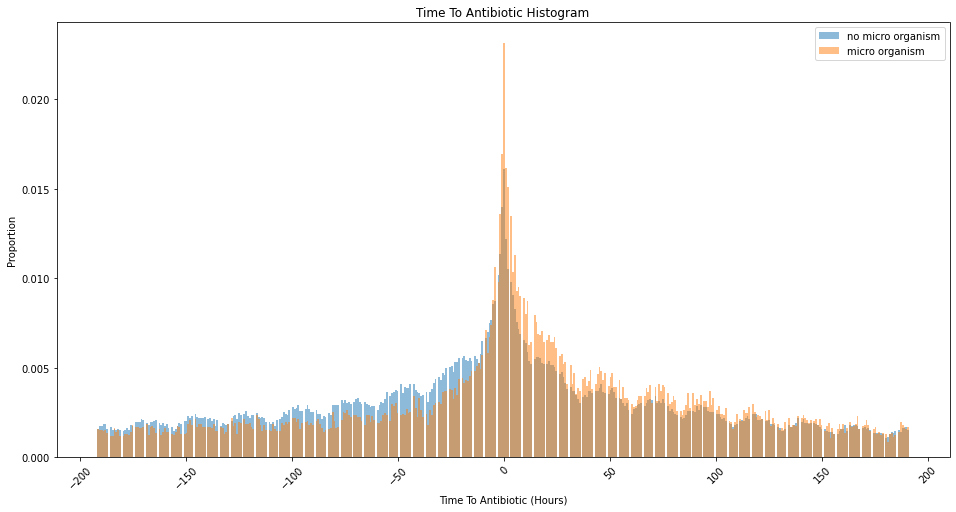

In [317]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation = 45)
plt.hist(timeToAntibioticDf1.time_to_antibiotic, density=True, bins=450, alpha=0.5, label='no micro organism')
plt.hist(timeToAntibioticDf2.time_to_antibiotic, density=True, bins=450, alpha=0.5, label='micro organism')

plt.legend(loc='upper right')

ax.set_title('Time To Antibiotic Histogram')
ax.set_xlabel('Time To Antibiotic (Hours)')
ax.set_ylabel('Proportion')

## Time to Antibiotic - All prescriptions - `S`, `I`, `R` Interpretations

In [109]:
timeToAntibioticSQuery = """
select
floor((extract(EPOCH from pr.starttime) - extract(EPOCH from mic.charttime))/3600) as time_to_antibiotic
from
mimiciv.microbiologyevents mic
inner join mimiciv.diagnoses_icd icd
on icd.hadm_id = mic.hadm_id and (icd.icd_code = '99591' OR icd.icd_code = '99592' or icd.icd_code = '78552' OR icd.icd_code = 'A419' OR icd.icd_code = 'R6520' OR icd.icd_code = 'R6521')
inner join mimiciv.prescriptions pr
on pr.hadm_id = mic.hadm_id and pr.starttime > mic.charttime - interval '192 hours' and pr.starttime < mic.charttime + interval '192 hours'
inner join sepsis.abx_poe_list ab
on pr.drug = ab.drug
where mic.interpretation = 'S'
;
"""
timeToAntibioticSDf = pd.read_sql_query(timeToAntibioticSQuery, con)
timeToAntibioticSDf

,time_to_antibiotic
0,-65.0
1,-34.0
2,19.0
3,92.0
4,-34.0
...,...
716990,13.0
716991,35.0
716992,71.0
716993,71.0


In [118]:
timeToAntibioticIQuery = """
select
floor((extract(EPOCH from pr.starttime) - extract(EPOCH from mic.charttime))/3600) as time_to_antibiotic
from
mimiciv.microbiologyevents mic
inner join mimiciv.diagnoses_icd icd
on icd.hadm_id = mic.hadm_id and (icd.icd_code = '99591' OR icd.icd_code = '99592' or icd.icd_code = '78552' OR icd.icd_code = 'A419' OR icd.icd_code = 'R6520' OR icd.icd_code = 'R6521')
inner join mimiciv.prescriptions pr
on pr.hadm_id = mic.hadm_id and pr.starttime > mic.charttime - interval '192 hours' and pr.starttime < mic.charttime + interval '192 hours'
inner join sepsis.abx_poe_list ab
on pr.drug = ab.drug
where mic.interpretation = 'I'
;
"""
timeToAntibioticIDf = pd.read_sql_query(timeToAntibioticIQuery, con)
timeToAntibioticIDf

,time_to_antibiotic
0,-165.0
1,-133.0
2,-119.0
3,-95.0
4,-81.0
...,...
38061,-37.0
38062,5.0
38063,79.0
38064,81.0


In [119]:
timeToAntibioticRQuery = """
    select
    floor((extract(EPOCH from pr.starttime) - extract(EPOCH from mic.charttime))/3600) as time_to_antibiotic
    from
    mimiciv.microbiologyevents mic
    inner join mimiciv.diagnoses_icd icd
    on icd.hadm_id = mic.hadm_id and (icd.icd_code = '99591' OR icd.icd_code = '99592' or icd.icd_code = '78552' OR icd.icd_code = 'A419' OR icd.icd_code = 'R6520' OR icd.icd_code = 'R6521')
    inner join mimiciv.prescriptions pr
    on pr.hadm_id = mic.hadm_id and pr.starttime > mic.charttime - interval '192 hours' and pr.starttime < mic.charttime + interval '192 hours'
    inner join sepsis.abx_poe_list ab
    on pr.drug = ab.drug
    where mic.interpretation = 'R'
;
"""
timeToAntibioticRDf = pd.read_sql_query(timeToAntibioticRQuery, con)
timeToAntibioticRDf

,time_to_antibiotic
0,-2.0
1,-34.0
2,19.0
3,92.0
4,-34.0
...,...
282969,-31.0
282970,67.0
282971,95.0
282972,98.0


Text(0, 0.5, 'Proportion')

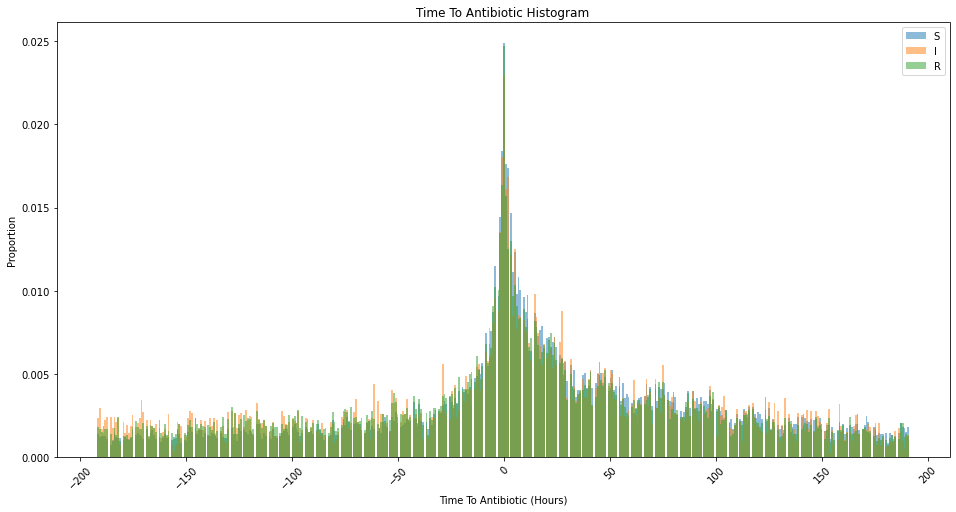

In [124]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation = 45)
plt.hist(timeToAntibioticSDf.time_to_antibiotic, density=True, bins=450, alpha=0.5, label='S')
plt.hist(timeToAntibioticIDf.time_to_antibiotic, density=True, bins=450, alpha=0.5, label='I')
plt.hist(timeToAntibioticRDf.time_to_antibiotic, density=True, bins=450, alpha=0.5, label='R')

plt.legend(loc='upper right')

ax.set_title('Time To Antibiotic Histogram')
ax.set_xlabel('Time To Antibiotic (Hours)')
ax.set_ylabel('Proportion')

In [127]:
timeToAntibioticQuery3 = """
    with t1 as(
        select
        floor((extract(EPOCH from pr.starttime) - extract(EPOCH from mic.charttime))/3600) as time_to_antibiotic,
        mic.microevent_id as micro_event_id,
        mic.micro_specimen_id as micro_specimen_id,
        mic.interpretation as interpretation,
        case mic.interpretation when 'S' then 1 when 'I' then 2 when 'R' then 3 else 0 end as interpretation_int
        from
        mimiciv.microbiologyevents mic
        inner join mimiciv.diagnoses_icd icd
        on icd.hadm_id = mic.hadm_id and (icd.icd_code = '99591' OR icd.icd_code = '99592' or icd.icd_code = '78552' OR icd.icd_code = 'A419' OR icd.icd_code = 'R6520' OR icd.icd_code = 'R6521')
        inner join mimiciv.prescriptions pr
        on pr.hadm_id = mic.hadm_id and pr.starttime > mic.charttime - interval '192 hours' and pr.starttime < mic.charttime + interval '192 hours'
        inner join sepsis.abx_poe_list ab
        on pr.drug = ab.drug
    ), t2 as (
        select
        distinct on (micro_event_id) micro_event_id, micro_specimen_id, interpretation_int, interpretation, time_to_antibiotic
        from
        t1
        order by micro_event_id, interpretation_int desc
    )
    select
    t2.interpretation,
    t2.time_to_antibiotic
    from t2
    ;
"""
timeToAntibioticDf3 = pd.read_sql_query(timeToAntibioticQuery3, con)
timeToAntibioticDf3

,interpretation,time_to_antibiotic
0,None,74.0
1,None,-13.0
2,None,39.0
3,None,-9.0
4,None,11.0
...,...,...
287909,None,53.0
287910,None,7.0
287911,None,-83.0
287912,None,-83.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


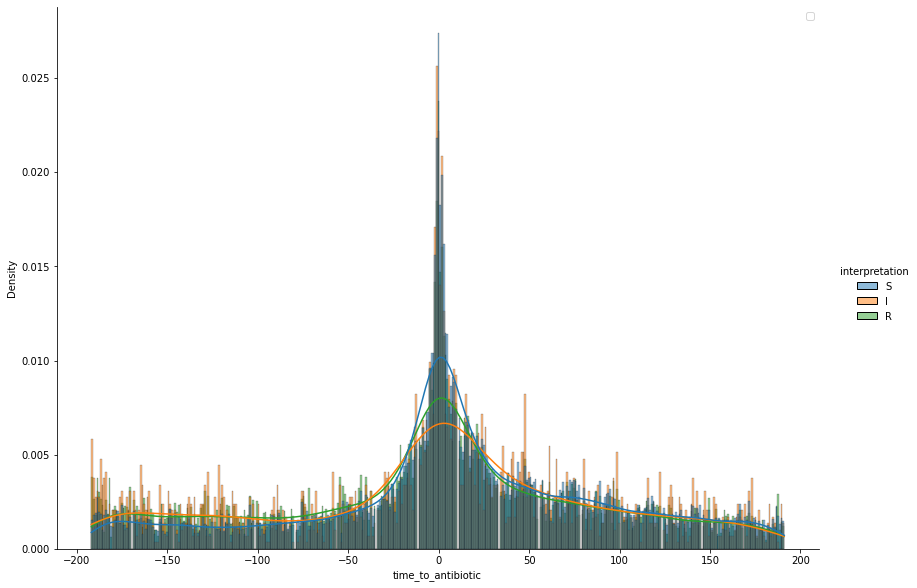

In [159]:
import seaborn as sns

sns.displot(timeToAntibioticDf3, x="time_to_antibiotic", hue="interpretation", stat="density", bins=400, common_norm=False, kde=True, height=8.27, aspect=11.7/8.27)

plt.legend(loc='upper right')

## Time to Antibiotic - First prescription - `Negative` vs `Positive` Cultures

In [318]:
timeToAntibioticQuery4 = """
with stg_1 as (
	select
    distinct
	first_value(mic_evt_1.subject_id) over (partition by mic_evt_1.micro_specimen_id) as subject_id,
	first_value(mic_evt_1.hadm_id) over (partition by mic_evt_1.micro_specimen_id) as hadm_id,
	min(mic_evt_1.charttime) over (partition by mic_evt_1.micro_specimen_id) as charttime,
	bool_or(mic_evt_1.org_name is not null) over (partition by mic_evt_1.micro_specimen_id) AS positive_culture
	from
	mimiciv.microbiologyevents mic_evt_1
)
, stg_2 as (
	select
	stg_1.subject_id,
	stg_1.charttime as charttime,
	bool_or(stg_1.positive_culture) as positive_culture,
	min(prx.starttime) as starttime
	from stg_1 stg_1
	inner join mimiciv.prescriptions prx
	on prx.subject_id = stg_1.subject_id
	and prx.starttime > stg_1.charttime - interval '192 hours'
	and prx.starttime < stg_1.charttime + interval '192 hours'
    inner join sepsis.abx_poe_list ab
    on prx.drug = ab.drug
    inner join mimiciv.diagnoses_icd icd
    on icd.hadm_id = stg_1.hadm_id and icd.icd_code in ('99591', '99592', '78552', 'A419', 'R6520', 'R6521')
	group by stg_1.subject_id, stg_1.charttime
)
select
floor((extract(epoch from stg_2.starttime) - extract(epoch from stg_2.charttime))/3600) as time_to_antibiotic,
positive_culture
from stg_2 stg_2
;
"""
timeToAntibioticDf4 = pd.read_sql_query(timeToAntibioticQuery4, con)
timeToAntibioticDf4

,time_to_antibiotic,positive_culture
0,-141.0,False
1,-143.0,True
2,-147.0,False
3,-185.0,False
4,-190.0,False
...,...,...
124842,-32.0,False
124843,-78.0,False
124844,-84.0,False
124845,-84.0,False


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


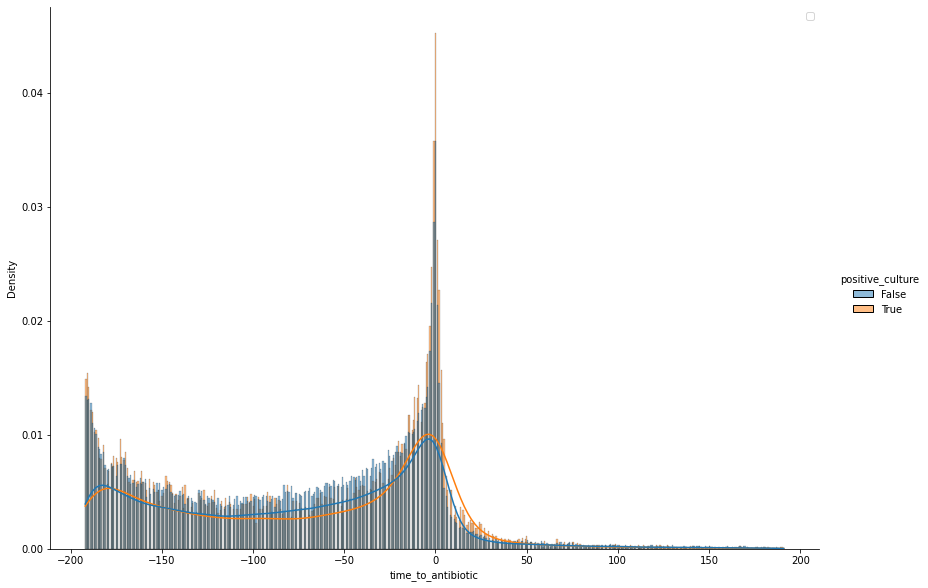

In [319]:
import seaborn as sns

sns.displot(timeToAntibioticDf4, x="time_to_antibiotic", hue="positive_culture", stat="density", bins=550, common_norm=False, kde=True, height=8.27, aspect=11.7/8.27)

plt.legend(loc='upper right')

Text(0, 0.5, 'Proportion')

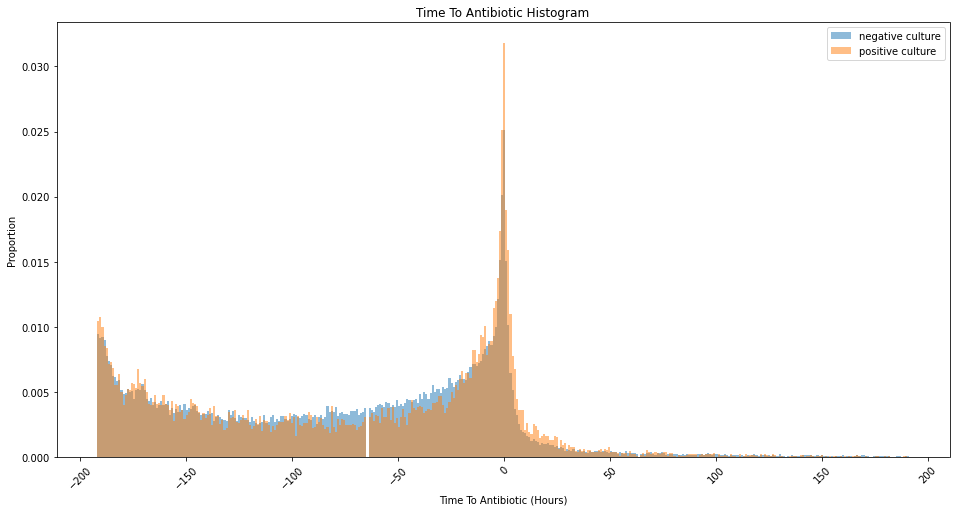

In [320]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation = 45)
plt.hist(timeToAntibioticDf4[timeToAntibioticDf4.positive_culture == False].time_to_antibiotic, density=True, bins=386, alpha=0.5, label='negative culture')
plt.hist(timeToAntibioticDf4[timeToAntibioticDf4.positive_culture == True].time_to_antibiotic, density=True, bins=386, alpha=0.5, label='positive culture')

plt.legend(loc='upper right')

ax.set_title('Time To Antibiotic Histogram')
ax.set_xlabel('Time To Antibiotic (Hours)')
ax.set_ylabel('Proportion')

## Time to Antibiotic - Last prescription - `Negative` vs `Positive` Cultures

In [330]:
timeToAntibioticQuery4_1 = """
with stg_1 as (
	select
    distinct
	first_value(mic_evt_1.subject_id) over (partition by mic_evt_1.micro_specimen_id) as subject_id,
	first_value(mic_evt_1.hadm_id) over (partition by mic_evt_1.micro_specimen_id) as hadm_id,
	min(mic_evt_1.charttime) over (partition by mic_evt_1.micro_specimen_id) as charttime,
	bool_or(mic_evt_1.org_name is not null) over (partition by mic_evt_1.micro_specimen_id) AS positive_culture
	from
	mimiciv.microbiologyevents mic_evt_1
)
, stg_2 as (
	select
	stg_1.subject_id,
	stg_1.charttime as charttime,
	bool_or(stg_1.positive_culture) as positive_culture,
	max(prx.starttime) as starttime
	from stg_1 stg_1
	inner join mimiciv.prescriptions prx
	on prx.subject_id = stg_1.subject_id
	and prx.starttime > stg_1.charttime - interval '192 hours'
	and prx.starttime < stg_1.charttime + interval '192 hours'
    inner join sepsis.abx_poe_list ab
    on prx.drug = ab.drug
    inner join mimiciv.diagnoses_icd icd
    on icd.hadm_id = stg_1.hadm_id and icd.icd_code in ('99591', '99592', '78552', 'A419', 'R6520', 'R6521')
	group by stg_1.subject_id, stg_1.charttime
)
select
floor((extract(epoch from stg_2.starttime) - extract(epoch from stg_2.charttime))/3600) as time_to_antibiotic,
positive_culture
from stg_2 stg_2
;
"""
timeToAntibioticDf4_1 = pd.read_sql_query(timeToAntibioticQuery4_1, con)
timeToAntibioticDf4_1

,time_to_antibiotic,positive_culture
0,-141.0,False
1,-143.0,True
2,-147.0,False
3,-185.0,False
4,-190.0,False
...,...,...
124842,53.0,False
124843,7.0,False
124844,1.0,False
124845,1.0,False


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


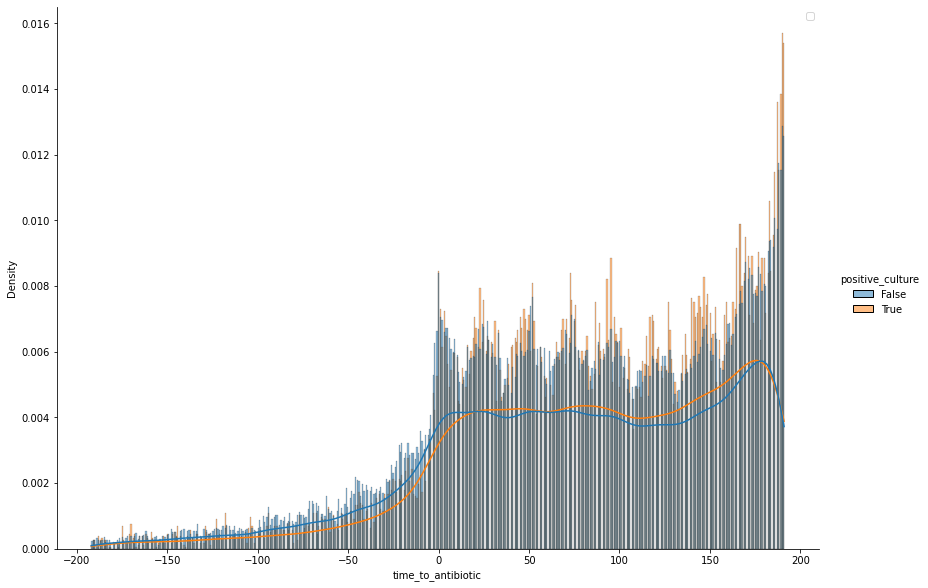

In [331]:
import seaborn as sns

sns.displot(timeToAntibioticDf4_1, x="time_to_antibiotic", hue="positive_culture", stat="density", bins=550, common_norm=False, kde=True, height=8.27, aspect=11.7/8.27)

plt.legend(loc='upper right')

Text(0, 0.5, 'Proportion')

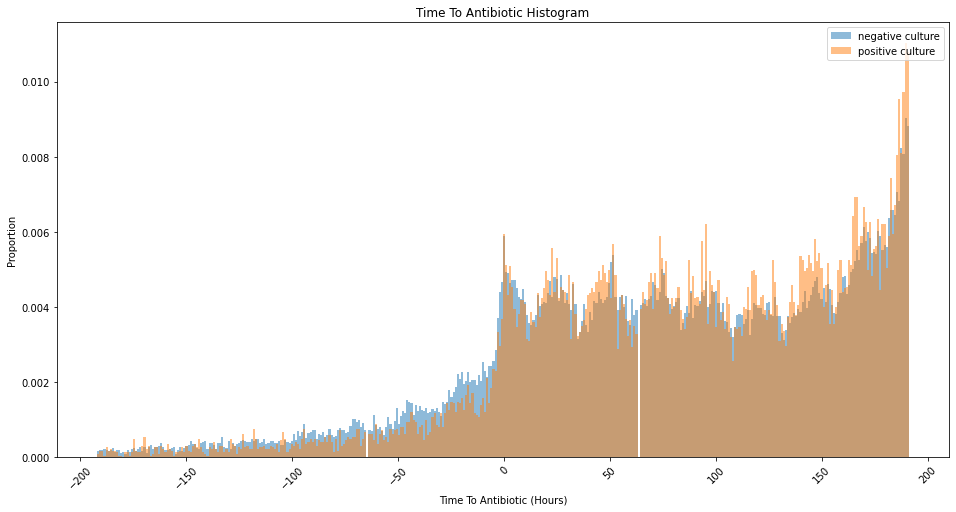

In [332]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation = 45)
plt.hist(timeToAntibioticDf4_1[timeToAntibioticDf4_1.positive_culture == False].time_to_antibiotic, density=True, bins=386, alpha=0.5, label='negative culture')
plt.hist(timeToAntibioticDf4_1[timeToAntibioticDf4_1.positive_culture == True].time_to_antibiotic, density=True, bins=386, alpha=0.5, label='positive culture')

plt.legend(loc='upper right')

ax.set_title('Time To Antibiotic Histogram')
ax.set_xlabel('Time To Antibiotic (Hours)')
ax.set_ylabel('Proportion')

## Time to Antibiotic - First prescription - `S`, `I`, `R` Interpretations

In [321]:
timeToAntibioticQuery5 = """
with lookup (lkp_key, lkp_value) as (values (null,0), ('S', 1), ('I', 2), ('R', 3))
, stg_1 as (
	select
	first_value(mic_evt_1.subject_id) over (partition by mic_evt_1.micro_specimen_id) as subject_id,
	first_value(mic_evt_1.hadm_id) over (partition by mic_evt_1.micro_specimen_id) as hadm_id,
	min(mic_evt_1.charttime) over (partition by mic_evt_1.micro_specimen_id) as charttime,
	lkp.lkp_value as interpretation
	from
	mimiciv.microbiologyevents mic_evt_1
	inner join lookup lkp
	on lkp.lkp_key = mic_evt_1.interpretation
)
, stg_2 as (
	select
	stg_1.subject_id,
	stg_1.charttime as charttime,
	stg_1.interpretation as interpretation,
	min(prx.starttime) as starttime
	from stg_1 stg_1
	inner join mimiciv.prescriptions prx
	on prx.subject_id = stg_1.subject_id
	and prx.starttime > stg_1.charttime - interval '192 hours'
	and prx.starttime < stg_1.charttime + interval '192 hours'
    inner join sepsis.abx_poe_list ab
    on prx.drug = ab.drug
    inner join mimiciv.diagnoses_icd icd
    on icd.hadm_id = stg_1.hadm_id and icd.icd_code in ('99591', '99592', '78552', 'A419', 'R6520', 'R6521')
	group by stg_1.subject_id, stg_1.charttime, stg_1.interpretation
)
select
floor((extract(epoch from stg_2.starttime) - extract(epoch from stg_2.charttime))/3600) as time_to_antibiotic,
interpretation
from stg_2 stg_2
;
"""
timeToAntibioticDf5 = pd.read_sql_query(timeToAntibioticQuery5, con)
timeToAntibioticDf5

,time_to_antibiotic,interpretation
0,2.0,1
1,2.0,2
2,2.0,3
3,-4.0,1
4,-22.0,1
...,...,...
15929,-1.0,3
15930,-79.0,1
15931,-79.0,1
15932,-6.0,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


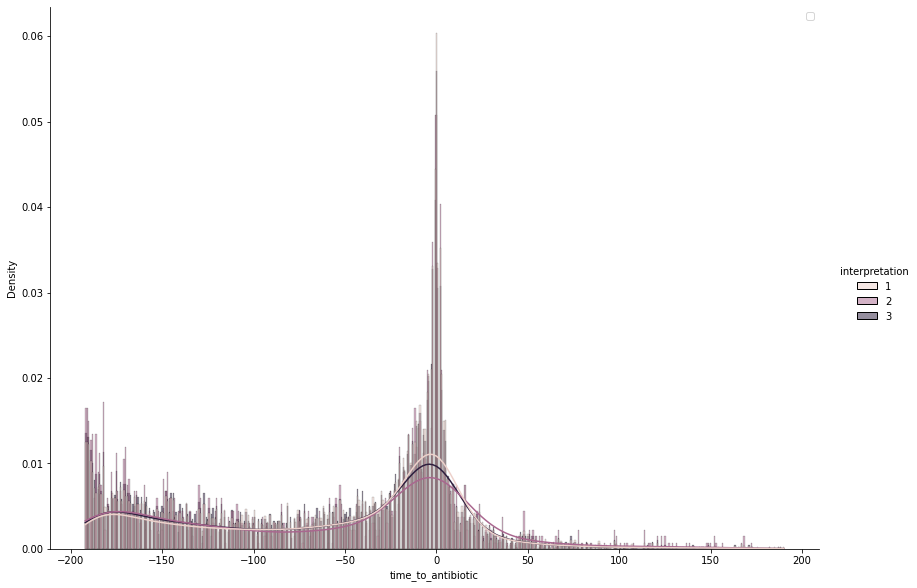

In [322]:
import seaborn as sns

sns.displot(timeToAntibioticDf5, x="time_to_antibiotic", hue="interpretation", stat="density", bins=550, common_norm=False, kde=True, height=8.27, aspect=11.7/8.27)

plt.legend(loc='upper right')

Text(0, 0.5, 'Proportion')

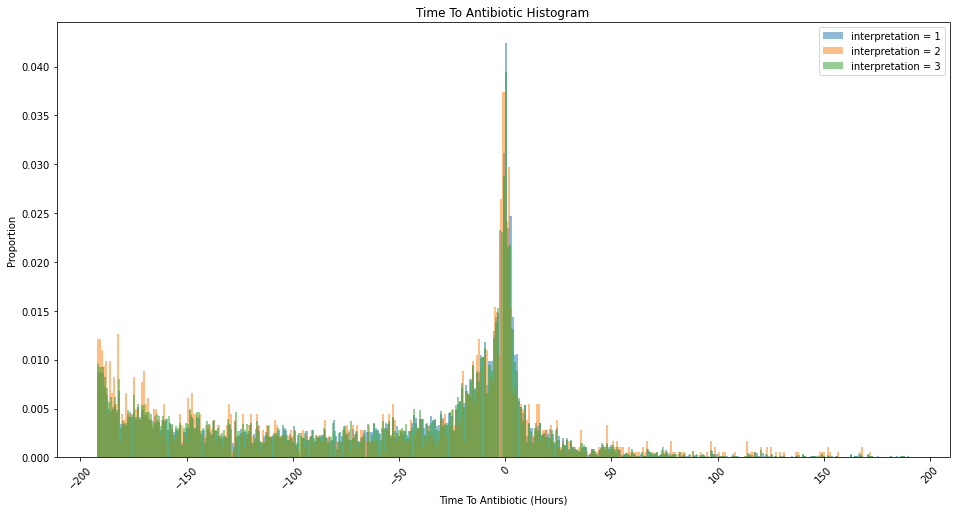

In [323]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation = 45)
plt.hist(timeToAntibioticDf5[timeToAntibioticDf5.interpretation == 1].time_to_antibiotic, density=True, bins=386, alpha=0.5, label='interpretation = 1')
plt.hist(timeToAntibioticDf5[timeToAntibioticDf5.interpretation == 2].time_to_antibiotic, density=True, bins=386, alpha=0.5, label='interpretation = 2')
plt.hist(timeToAntibioticDf5[timeToAntibioticDf5.interpretation == 3].time_to_antibiotic, density=True, bins=386, alpha=0.5, label='interpretation = 3')

plt.legend(loc='upper right')

ax.set_title('Time To Antibiotic Histogram')
ax.set_xlabel('Time To Antibiotic (Hours)')
ax.set_ylabel('Proportion')

## Time to Antibiotic - Last prescription - `S`, `I`, `R` Interpretations

In [333]:
timeToAntibioticQuery5_1 = """
with lookup (lkp_key, lkp_value) as (values (null,0), ('S', 1), ('I', 2), ('R', 3))
, stg_1 as (
	select
	first_value(mic_evt_1.subject_id) over (partition by mic_evt_1.micro_specimen_id) as subject_id,
	first_value(mic_evt_1.hadm_id) over (partition by mic_evt_1.micro_specimen_id) as hadm_id,
	min(mic_evt_1.charttime) over (partition by mic_evt_1.micro_specimen_id) as charttime,
	lkp.lkp_value as interpretation
	from
	mimiciv.microbiologyevents mic_evt_1
	inner join lookup lkp
	on lkp.lkp_key = mic_evt_1.interpretation
)
, stg_2 as (
	select
	stg_1.subject_id,
	stg_1.charttime as charttime,
	stg_1.interpretation as interpretation,
	max(prx.starttime) as starttime
	from stg_1 stg_1
	inner join mimiciv.prescriptions prx
	on prx.subject_id = stg_1.subject_id
	and prx.starttime > stg_1.charttime - interval '192 hours'
	and prx.starttime < stg_1.charttime + interval '192 hours'
    inner join sepsis.abx_poe_list ab
    on prx.drug = ab.drug
    inner join mimiciv.diagnoses_icd icd
    on icd.hadm_id = stg_1.hadm_id and icd.icd_code in ('99591', '99592', '78552', 'A419', 'R6520', 'R6521')
	group by stg_1.subject_id, stg_1.charttime, stg_1.interpretation
)
select
floor((extract(epoch from stg_2.starttime) - extract(epoch from stg_2.charttime))/3600) as time_to_antibiotic,
interpretation
from stg_2 stg_2
;
"""
timeToAntibioticDf5_1 = pd.read_sql_query(timeToAntibioticQuery5_1, con)
timeToAntibioticDf5_1

,time_to_antibiotic,interpretation
0,188.0,1
1,188.0,2
2,188.0,3
3,100.0,1
4,82.0,1
...,...,...
15929,77.0,3
15930,74.0,1
15931,74.0,1
15932,170.0,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


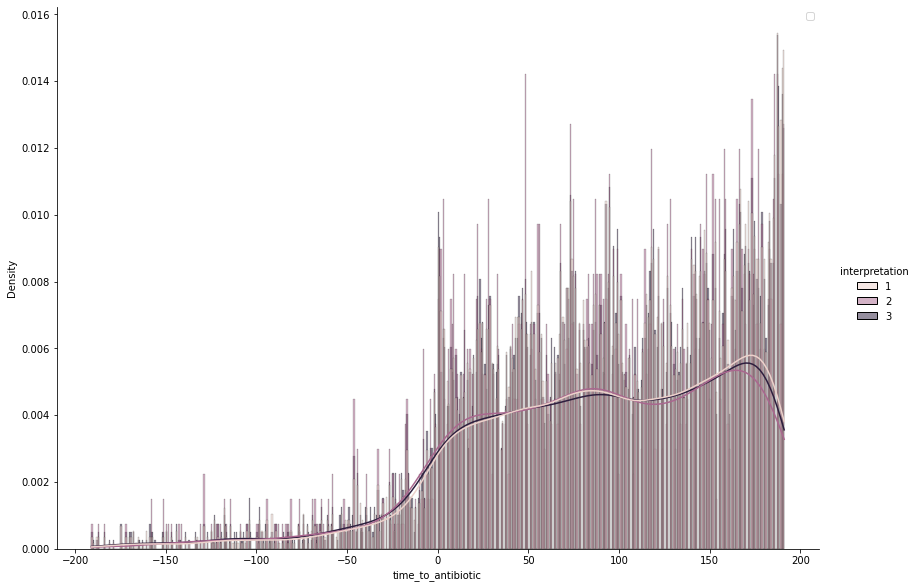

In [334]:
import seaborn as sns

sns.displot(timeToAntibioticDf6, x="time_to_antibiotic", hue="interpretation", stat="density", bins=550, common_norm=False, kde=True, height=8.27, aspect=11.7/8.27)

plt.legend(loc='upper right')

Text(0, 0.5, 'Proportion')

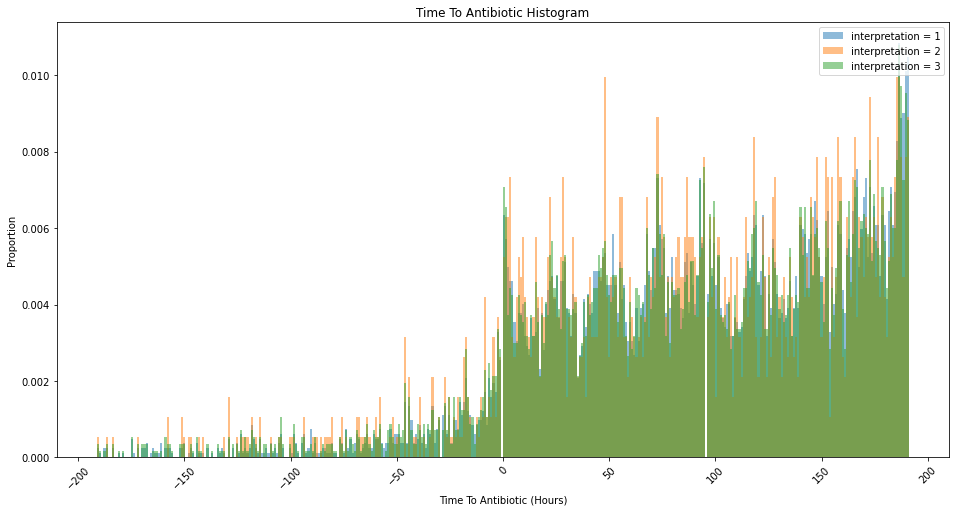

In [335]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation = 45)
plt.hist(timeToAntibioticDf6[timeToAntibioticDf6.interpretation == 1].time_to_antibiotic, density=True, bins=386, alpha=0.5, label='interpretation = 1')
plt.hist(timeToAntibioticDf6[timeToAntibioticDf6.interpretation == 2].time_to_antibiotic, density=True, bins=386, alpha=0.5, label='interpretation = 2')
plt.hist(timeToAntibioticDf6[timeToAntibioticDf6.interpretation == 3].time_to_antibiotic, density=True, bins=386, alpha=0.5, label='interpretation = 3')

plt.legend(loc='upper right')

ax.set_title('Time To Antibiotic Histogram')
ax.set_xlabel('Time To Antibiotic (Hours)')
ax.set_ylabel('Proportion')

## Time to Antibiotic - Changed prescription - `Negative` vs `Positive` Cultures

In [337]:
timeToAntibioticQuery6 = """
with first_mic_evt as (
	select
    distinct
	first_value(mic_evt_1.subject_id) over (partition by mic_evt_1.micro_specimen_id) as subject_id,
	first_value(mic_evt_1.hadm_id) over (partition by mic_evt_1.micro_specimen_id) as hadm_id,
	min(mic_evt_1.charttime) over (partition by mic_evt_1.micro_specimen_id) as charttime,
	bool_or(mic_evt_1.org_name is not null) over (partition by mic_evt_1.micro_specimen_id) AS positive_culture
	from
	mimiciv.microbiologyevents mic_evt_1
)
, stg_2 as (
	select
	first_mic_evt.subject_id,
	first_mic_evt.charttime as charttime,
	bool_or(first_mic_evt.positive_culture) as positive_culture,
	prx.starttime as starttime
	from first_mic_evt first_mic_evt
	inner join mimiciv.prescriptions prx
	on prx.subject_id = first_mic_evt.subject_id
	and prx.starttime > first_mic_evt.charttime - interval '192 hours'
	and prx.starttime < first_mic_evt.charttime + interval '192 hours'
	and exists (
		select
		1
		from mimiciv.prescriptions prx_inr
		where prx_inr.subject_id = prx.subject_id
		and prx_inr.hadm_id = prx.hadm_id
		and prx_inr.drug_type != prx.drug_type
		and prx_inr.drug != prx.drug
        and prx_inr.starttime > first_mic_evt.charttime - interval '192 hours'
        and prx_inr.starttime < first_mic_evt.charttime + interval '192 hours'
		and prx_inr.starttime > prx.starttime
		and prx_inr.starttime < prx.starttime + interval '2 hours'
	)
	inner join sepsis.abx_poe_list ab
	on prx.drug = ab.drug
    inner join mimiciv.diagnoses_icd icd
    on icd.hadm_id = first_mic_evt.hadm_id and icd.icd_code in ('99591', '99592', '78552', 'A419', 'R6520', 'R6521')
	group by first_mic_evt.subject_id, first_mic_evt.charttime, prx.starttime
)
select
floor((extract(epoch from stg_2.starttime) - extract(epoch from stg_2.charttime))/3600) as time_to_antibiotic,
positive_culture
from stg_2 stg_2
;
"""
timeToAntibioticDf6 = pd.read_sql_query(timeToAntibioticQuery6, con)
timeToAntibioticDf6

,time_to_antibiotic,positive_culture
0,-11.0,False
1,-13.0,False
2,-16.0,False
3,-35.0,True
4,-35.0,False
...,...,...
156203,-83.0,False
156204,-84.0,False
156205,-83.0,False
156206,-85.0,True


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


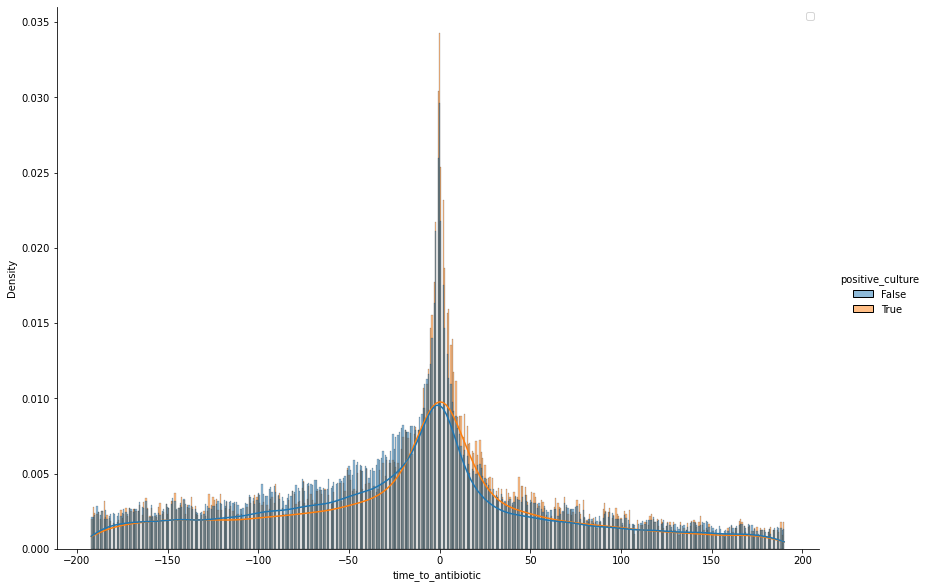

In [338]:
import seaborn as sns

sns.displot(timeToAntibioticDf6, x="time_to_antibiotic", hue="positive_culture", stat="density", bins=550, common_norm=False, kde=True, height=8.27, aspect=11.7/8.27)

plt.legend(loc='upper right')

Text(0, 0.5, 'Proportion')

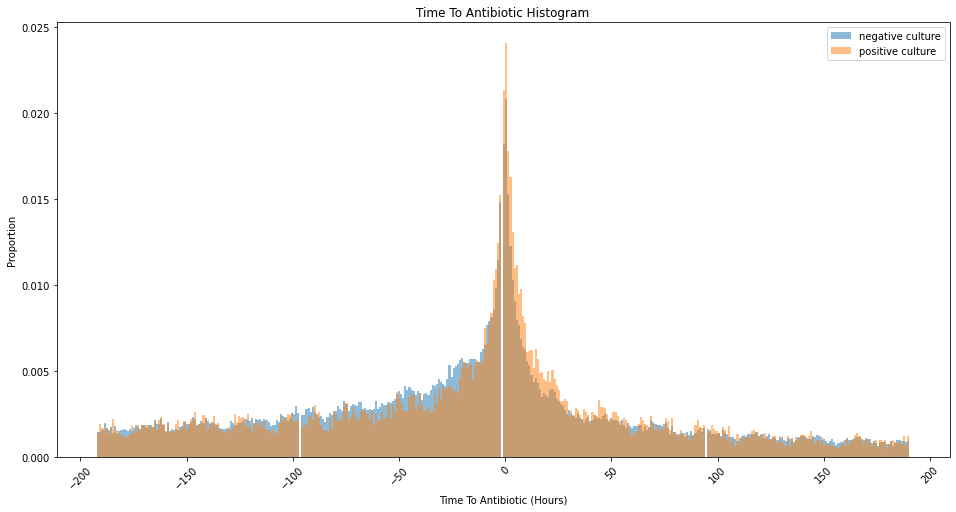

In [339]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation = 45)
plt.hist(timeToAntibioticDf6[timeToAntibioticDf6.positive_culture == False].time_to_antibiotic, density=True, bins=386, alpha=0.5, label='negative culture')
plt.hist(timeToAntibioticDf6[timeToAntibioticDf6.positive_culture == True].time_to_antibiotic, density=True, bins=386, alpha=0.5, label='positive culture')

plt.legend(loc='upper right')

ax.set_title('Time To Antibiotic Histogram')
ax.set_xlabel('Time To Antibiotic (Hours)')
ax.set_ylabel('Proportion')

## Time to Antibiotic - Changed prescription - `S`, `I`, `R` Interpretations

In [340]:
timeToAntibioticQuery7 = """
with lookup (lkp_key, lkp_value) as (values (null,0), ('S', 1), ('I', 2), ('R', 3))
, changed_prx as (
	select prx.* from mimiciv.prescriptions prx
	inner join sepsis.abx_poe_list ab
	on prx.drug = ab.drug
	where
	exists (
		select
		1
		from mimiciv.prescriptions prx_inr
		where prx_inr.subject_id = prx.subject_id
		and prx_inr.hadm_id = prx.hadm_id
		and prx_inr.drug_type != prx.drug_type
		and prx_inr.drug != prx.drug
		and prx_inr.starttime < prx.starttime
	)
)
, first_mic_evt as (
	select
    distinct
	first_value(mic_evt_1.subject_id) over (partition by mic_evt_1.micro_specimen_id) as subject_id,
	first_value(mic_evt_1.hadm_id) over (partition by mic_evt_1.micro_specimen_id) as hadm_id,
	min(mic_evt_1.charttime) over (partition by mic_evt_1.micro_specimen_id) as charttime,
	lkp.lkp_value as interpretation
	from
	mimiciv.microbiologyevents mic_evt_1
	inner join lookup lkp
	on lkp.lkp_key = mic_evt_1.interpretation
)
, stg_2 as (
	select
	first_mic_evt.subject_id,
	first_mic_evt.charttime as charttime,
	first_mic_evt.interpretation as interpretation,
	min(prx.starttime) as starttime
	from first_mic_evt first_mic_evt
	inner join changed_prx prx
	on prx.subject_id = first_mic_evt.subject_id
	and prx.starttime > first_mic_evt.charttime - interval '192 hours'
	and prx.starttime < first_mic_evt.charttime + interval '192 hours'
    inner join mimiciv.diagnoses_icd icd
    on icd.hadm_id = first_mic_evt.hadm_id and icd.icd_code in ('99591', '99592', '78552', 'A419', 'R6520', 'R6521')
	group by first_mic_evt.subject_id, first_mic_evt.charttime, first_mic_evt.interpretation
)
select
floor((extract(epoch from stg_2.starttime) - extract(epoch from stg_2.charttime))/3600) as time_to_antibiotic,
interpretation
from stg_2 stg_2
;
"""
timeToAntibioticDf7 = pd.read_sql_query(timeToAntibioticQuery7, con)
timeToAntibioticDf7

,time_to_antibiotic,interpretation
0,2.0,1
1,2.0,2
2,2.0,3
3,-4.0,1
4,-22.0,1
...,...,...
15861,-1.0,3
15862,-79.0,1
15863,-79.0,1
15864,-6.0,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


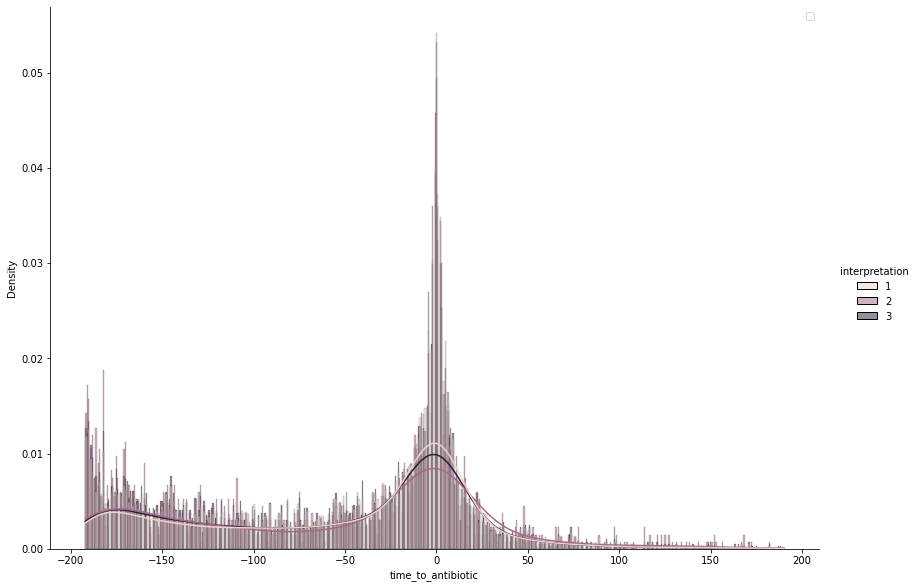

In [341]:
import seaborn as sns

sns.displot(timeToAntibioticDf7, x="time_to_antibiotic", hue="interpretation", stat="density", bins=550, common_norm=False, kde=True, height=8.27, aspect=11.7/8.27)

plt.legend(loc='upper right')

Text(0, 0.5, 'Proportion')

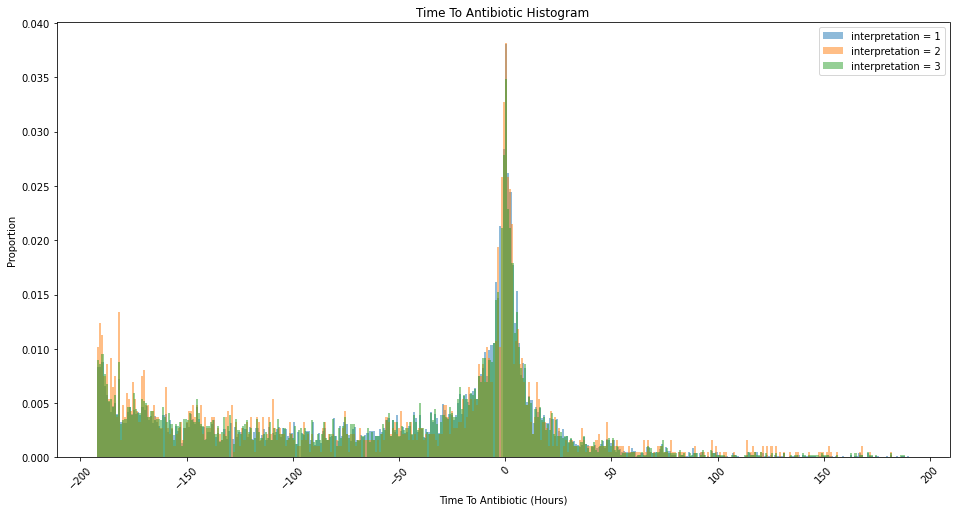

In [342]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation = 45)
plt.hist(timeToAntibioticDf7[timeToAntibioticDf7.interpretation == 1].time_to_antibiotic, density=True, bins=386, alpha=0.5, label='interpretation = 1')
plt.hist(timeToAntibioticDf7[timeToAntibioticDf7.interpretation == 2].time_to_antibiotic, density=True, bins=386, alpha=0.5, label='interpretation = 2')
plt.hist(timeToAntibioticDf7[timeToAntibioticDf7.interpretation == 3].time_to_antibiotic, density=True, bins=386, alpha=0.5, label='interpretation = 3')

plt.legend(loc='upper right')

ax.set_title('Time To Antibiotic Histogram')
ax.set_xlabel('Time To Antibiotic (Hours)')
ax.set_ylabel('Proportion')

## Time to Antibiotic - All antibiotic inputs - `Negative` vs `Positive` Cultures

In [269]:
timeToAntibioticQuery8 = """
with first_mic_evt as (
	select
    distinct
	first_value(mic_evt_1.subject_id) over (partition by mic_evt_1.micro_specimen_id) as subject_id,
	min(mic_evt_1.charttime) over (partition by mic_evt_1.micro_specimen_id) as charttime,
	bool_or(mic_evt_1.org_name is not null) over (partition by mic_evt_1.micro_specimen_id) AS positive_culture
	from
	mimiciv.microbiologyevents mic_evt_1
)
, stg_2 as (
	select
	first_mic_evt.subject_id as subject_id,
	first_mic_evt.charttime as charttime,
	ipt.starttime as starttime,
	bool_or(first_mic_evt.positive_culture) as positive_culture
	from
	first_mic_evt first_mic_evt
	inner join mimiciv.inputevents ipt
	on ipt.subject_id = first_mic_evt.subject_id
	and ipt.starttime > first_mic_evt.charttime - interval '240 hours'
	and ipt.starttime < first_mic_evt.charttime + interval '240 hours'
	inner join mimiciv.d_items lkp
	on lkp.itemid = ipt.itemid and lkp.category = 'Antibiotics'
	group by first_mic_evt.subject_id, first_mic_evt.charttime, ipt.starttime
	)
select
floor((extract(epoch from stg_2.starttime) - extract(epoch from stg_2.charttime))/3600) as time_to_antibiotic,
positive_culture
from stg_2 stg_2
;
"""
timeToAntibioticDf8 = pd.read_sql_query(timeToAntibioticQuery8, con)
timeToAntibioticDf8

,time_to_antibiotic,positive_culture
0,0.0,False
1,3.0,False
2,4.0,False
3,-4.0,False
4,-1.0,False
...,...,...
5980175,-6.0,False
5980176,-5.0,False
5980177,-4.0,False
5980178,-3.0,False


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


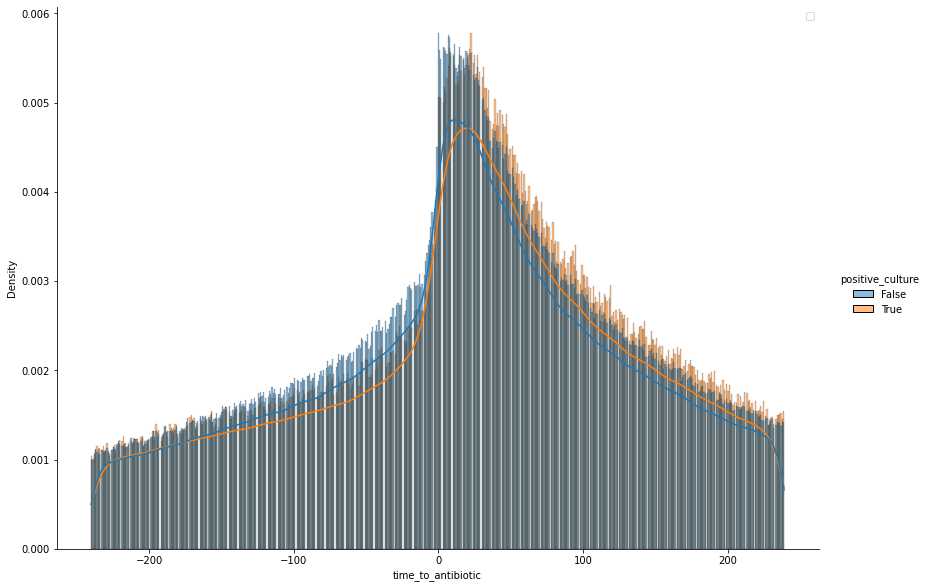

In [270]:
import seaborn as sns

sns.displot(timeToAntibioticDf8, x="time_to_antibiotic", hue="positive_culture", stat="density", bins=550, common_norm=False, kde=True, height=8.27, aspect=11.7/8.27)

plt.legend(loc='upper right')

Text(0, 0.5, 'Proportion')

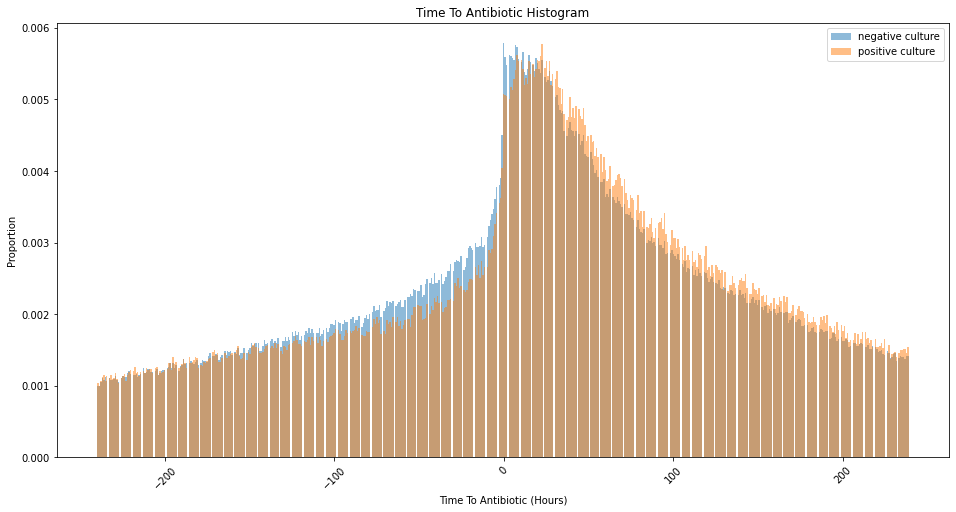

In [276]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation = 45)
plt.hist(timeToAntibioticDf8[timeToAntibioticDf8.positive_culture == False].time_to_antibiotic, density=True, bins=550, alpha=0.5, label='negative culture')
plt.hist(timeToAntibioticDf8[timeToAntibioticDf8.positive_culture == True].time_to_antibiotic, density=True, bins=550, alpha=0.5, label='positive culture')

plt.legend(loc='upper right')

ax.set_title('Time To Antibiotic Histogram')
ax.set_xlabel('Time To Antibiotic (Hours)')
ax.set_ylabel('Proportion')

## Time to Antibiotic - All antibiotic inputs - `S`, `I`, and `R` Interpretations

In [278]:
timeToAntibioticQuery9 = """
with first_mic_evt as (
	select
	distinct
	first_value(mic_evt_1.subject_id) over (partition by mic_evt_1.micro_specimen_id) as subject_id,
	min(mic_evt_1.charttime) over (partition by mic_evt_1.micro_specimen_id) as charttime,
	mic_evt_1.interpretation as interpretation
	from
	mimiciv.microbiologyevents mic_evt_1
)
, stg_2 as (
	select
	first_mic_evt.subject_id as subject_id,
	first_mic_evt.charttime as charttime,
	ipt.starttime as starttime,
	interpretation as interpretation
	from
	first_mic_evt first_mic_evt
	inner join mimiciv.inputevents ipt
	on ipt.subject_id = first_mic_evt.subject_id
	and ipt.starttime > first_mic_evt.charttime - interval '240 hours'
	and ipt.starttime < first_mic_evt.charttime + interval '240 hours'
	inner join mimiciv.d_items lkp
	on lkp.itemid = ipt.itemid and lkp.category = 'Antibiotics'
	group by first_mic_evt.subject_id, first_mic_evt.charttime, ipt.starttime, interpretation
)
select
floor((extract(epoch from stg_2.starttime) - extract(epoch from stg_2.charttime))/3600) as time_to_antibiotic,
interpretation
from stg_2 stg_2
;
"""
timeToAntibioticDf9 = pd.read_sql_query(timeToAntibioticQuery9, con)
timeToAntibioticDf9

,time_to_antibiotic,interpretation
0,0.0,None
1,3.0,None
2,4.0,None
3,-4.0,None
4,-1.0,None
...,...,...
6702707,-6.0,None
6702708,-5.0,None
6702709,-4.0,None
6702710,-3.0,None


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


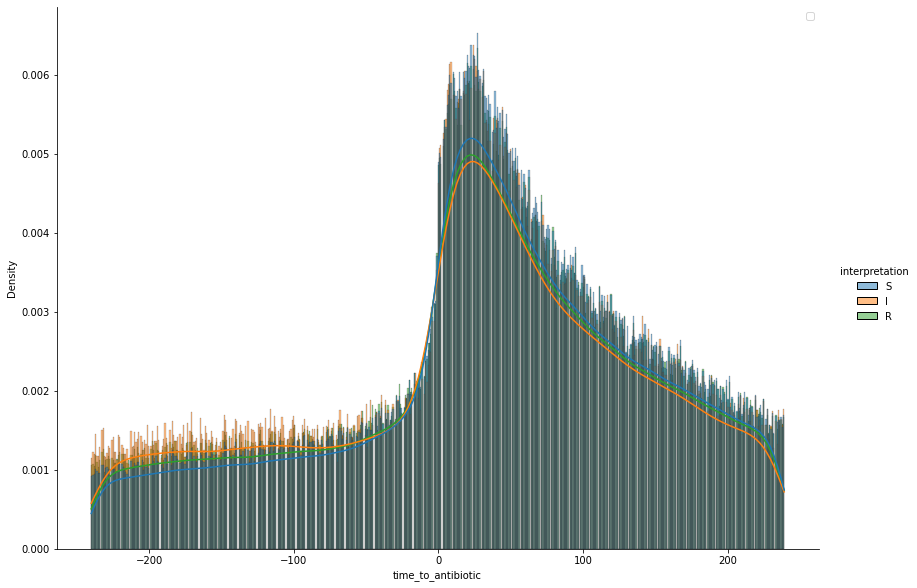

In [281]:
import seaborn as sns

sns.displot(timeToAntibioticDf9, x="time_to_antibiotic", hue="interpretation", stat="density", bins=550, common_norm=False, kde=True, height=8.27, aspect=11.7/8.27)

plt.legend(loc='upper right')

Text(0, 0.5, 'Proportion')

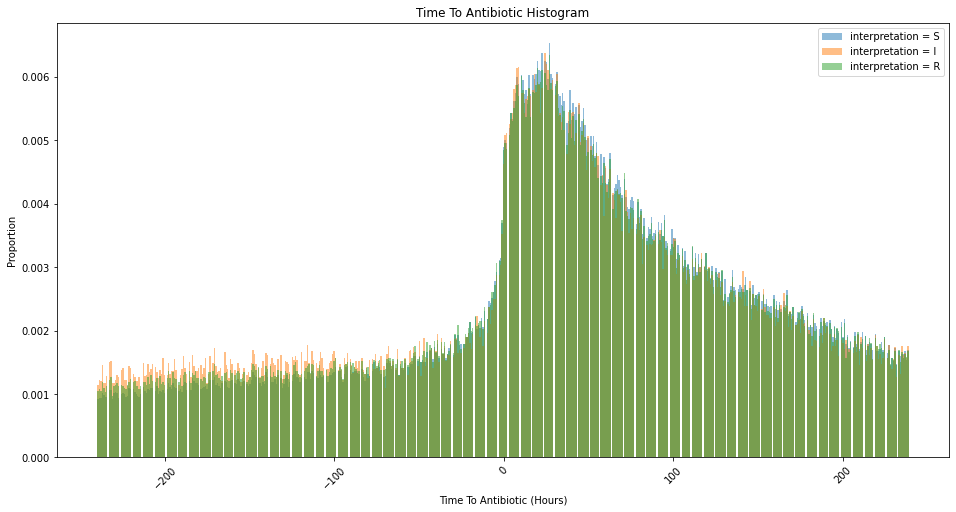

In [284]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation = 45)
plt.hist(timeToAntibioticDf9[timeToAntibioticDf9.interpretation == 'S'].time_to_antibiotic, density=True, bins=550, alpha=0.5, label='interpretation = S')
plt.hist(timeToAntibioticDf9[timeToAntibioticDf9.interpretation == 'I'].time_to_antibiotic, density=True, bins=550, alpha=0.5, label='interpretation = I')
plt.hist(timeToAntibioticDf9[timeToAntibioticDf9.interpretation == 'R'].time_to_antibiotic, density=True, bins=550, alpha=0.5, label='interpretation = R')

plt.legend(loc='upper right')

ax.set_title('Time To Antibiotic Histogram')
ax.set_xlabel('Time To Antibiotic (Hours)')
ax.set_ylabel('Proportion')

## Time to Antibiotic - First antibiotic input - `Negative` vs `Positive` Cultures

In [285]:
timeToAntibioticQuery10 = """
with first_mic_evt as (
	select
    distinct
	first_value(mic_evt_1.subject_id) over (partition by mic_evt_1.micro_specimen_id) as subject_id,
	min(mic_evt_1.charttime) over (partition by mic_evt_1.micro_specimen_id) as charttime,
	bool_or(mic_evt_1.org_name is not null) over (partition by mic_evt_1.micro_specimen_id) AS positive_culture
	from
	mimiciv.microbiologyevents mic_evt_1
)
, stg_2 as (
	select
	first_mic_evt.subject_id as subject_id,
	first_mic_evt.charttime as charttime,
	min(ipt.starttime) as starttime,
	bool_or(first_mic_evt.positive_culture) as positive_culture
	from
	first_mic_evt first_mic_evt
	inner join mimiciv.inputevents ipt
	on ipt.subject_id = first_mic_evt.subject_id
	and ipt.starttime > first_mic_evt.charttime - interval '240 hours'
	and ipt.starttime < first_mic_evt.charttime + interval '240 hours'
	inner join mimiciv.d_items lkp
	on lkp.itemid = ipt.itemid and lkp.category = 'Antibiotics'
	group by first_mic_evt.subject_id, first_mic_evt.charttime
	)
select
floor((extract(epoch from stg_2.starttime) - extract(epoch from stg_2.charttime))/3600) as time_to_antibiotic,
positive_culture
from stg_2 stg_2
;
"""
timeToAntibioticDf10 = pd.read_sql_query(timeToAntibioticQuery10, con)
timeToAntibioticDf10

,time_to_antibiotic,positive_culture
0,0.0,False
1,-4.0,False
2,46.0,False
3,41.0,False
4,35.0,False
...,...,...
304336,8.0,False
304337,7.0,True
304338,-39.0,False
304339,-105.0,False


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


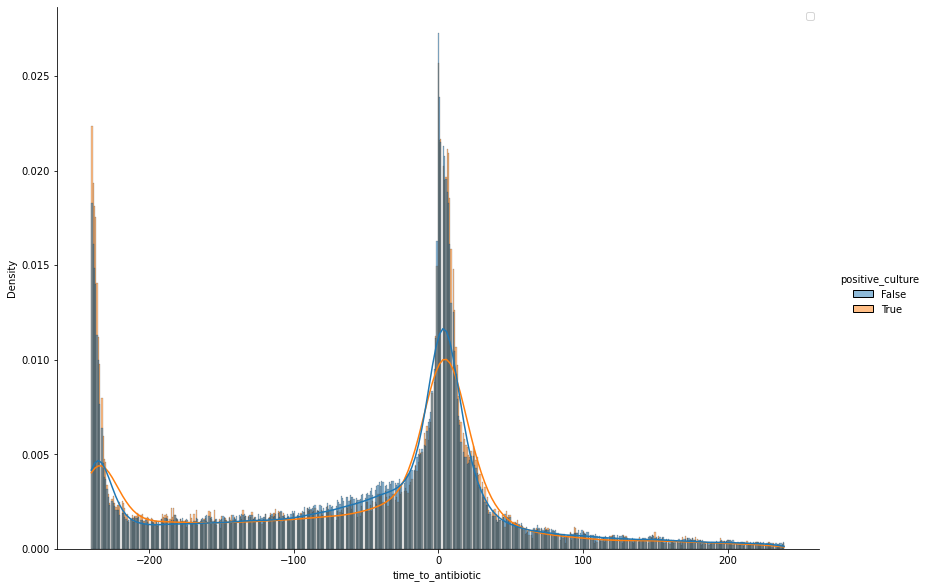

In [286]:
import seaborn as sns

sns.displot(timeToAntibioticDf10, x="time_to_antibiotic", hue="positive_culture", stat="density", bins=550, common_norm=False, kde=True, height=8.27, aspect=11.7/8.27)

plt.legend(loc='upper right')

Text(0, 0.5, 'Proportion')

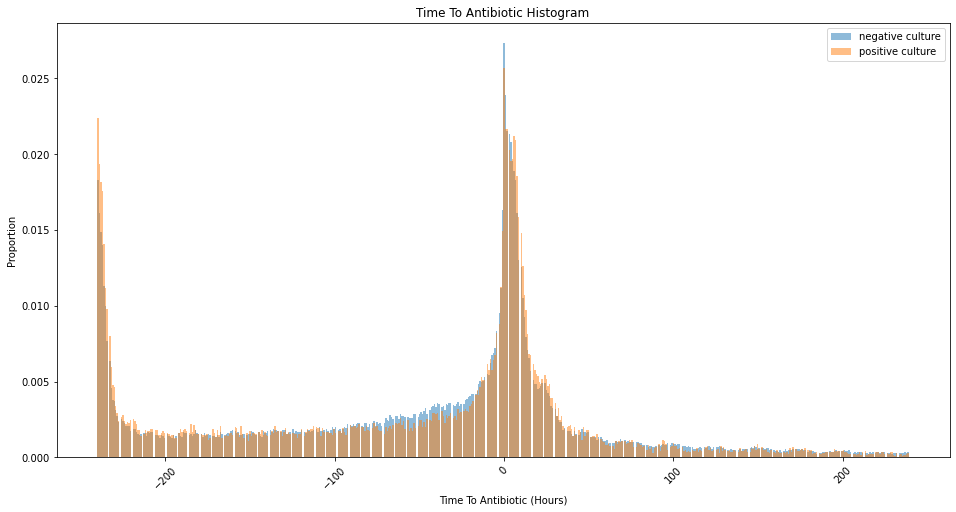

In [288]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation = 45)
plt.hist(timeToAntibioticDf10[timeToAntibioticDf10.positive_culture == False].time_to_antibiotic, density=True, bins=550, alpha=0.5, label='negative culture')
plt.hist(timeToAntibioticDf10[timeToAntibioticDf10.positive_culture == True].time_to_antibiotic, density=True, bins=550, alpha=0.5, label='positive culture')

plt.legend(loc='upper right')

ax.set_title('Time To Antibiotic Histogram')
ax.set_xlabel('Time To Antibiotic (Hours)')
ax.set_ylabel('Proportion')

## Time to Antibiotic - Last antibiotic input - `Negative` vs `Positive` Cultures

In [289]:
timeToAntibioticQuery11 = """
with first_mic_evt as (
	select
    distinct
	first_value(mic_evt_1.subject_id) over (partition by mic_evt_1.micro_specimen_id) as subject_id,
	min(mic_evt_1.charttime) over (partition by mic_evt_1.micro_specimen_id) as charttime,
	bool_or(mic_evt_1.org_name is not null) over (partition by mic_evt_1.micro_specimen_id) AS positive_culture
	from
	mimiciv.microbiologyevents mic_evt_1
)
, stg_2 as (
	select
	first_mic_evt.subject_id as subject_id,
	first_mic_evt.charttime as charttime,
	max(ipt.starttime) as starttime,
	bool_or(first_mic_evt.positive_culture) as positive_culture
	from
	first_mic_evt first_mic_evt
	inner join mimiciv.inputevents ipt
	on ipt.subject_id = first_mic_evt.subject_id
	and ipt.starttime > first_mic_evt.charttime - interval '240 hours'
	and ipt.starttime < first_mic_evt.charttime + interval '240 hours'
	inner join mimiciv.d_items lkp
	on lkp.itemid = ipt.itemid and lkp.category = 'Antibiotics'
	group by first_mic_evt.subject_id, first_mic_evt.charttime
	)
select
floor((extract(epoch from stg_2.starttime) - extract(epoch from stg_2.charttime))/3600) as time_to_antibiotic,
positive_culture
from stg_2 stg_2
;
"""
timeToAntibioticDf11 = pd.read_sql_query(timeToAntibioticQuery11, con)
timeToAntibioticDf11

,time_to_antibiotic,positive_culture
0,4.0,False
1,1.0,False
2,67.0,False
3,62.0,False
4,56.0,False
...,...,...
304336,116.0,False
304337,116.0,True
304338,70.0,False
304339,4.0,False


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


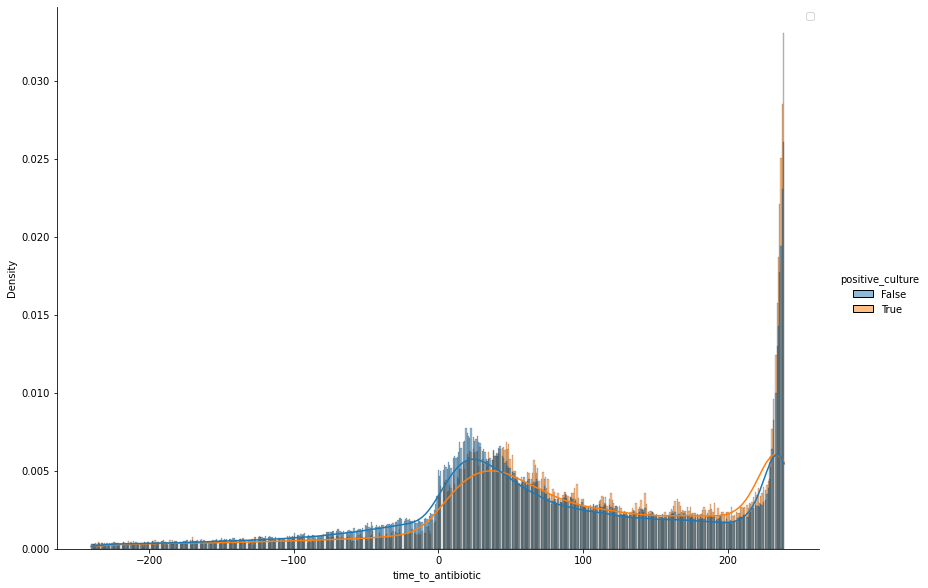

In [290]:
import seaborn as sns

sns.displot(timeToAntibioticDf11, x="time_to_antibiotic", hue="positive_culture", stat="density", bins=550, common_norm=False, kde=True, height=8.27, aspect=11.7/8.27)

plt.legend(loc='upper right')

Text(0, 0.5, 'Proportion')

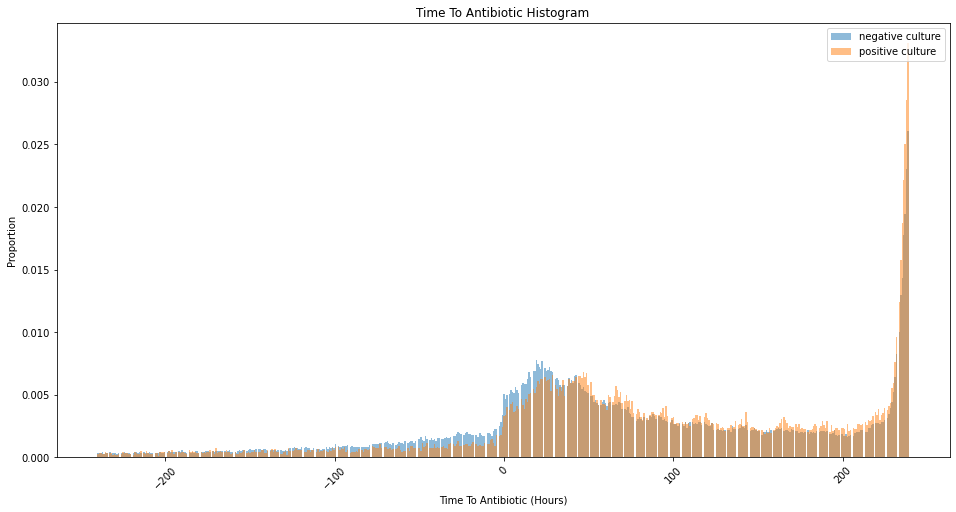

In [291]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation = 45)
plt.hist(timeToAntibioticDf11[timeToAntibioticDf11.positive_culture == False].time_to_antibiotic, density=True, bins=550, alpha=0.5, label='negative culture')
plt.hist(timeToAntibioticDf11[timeToAntibioticDf11.positive_culture == True].time_to_antibiotic, density=True, bins=550, alpha=0.5, label='positive culture')

plt.legend(loc='upper right')

ax.set_title('Time To Antibiotic Histogram')
ax.set_xlabel('Time To Antibiotic (Hours)')
ax.set_ylabel('Proportion')

## Time to Antibiotic - Changed antibiotic input - `Negative` vs `Positive` Cultures

In [305]:
timeToAntibioticQuery12 = """
with first_mic_evt as (
	select
	distinct
	first_value(mic_evt_1.subject_id) over (partition by mic_evt_1.micro_specimen_id) as subject_id,
	min(mic_evt_1.charttime) over (partition by mic_evt_1.micro_specimen_id) as charttime,
	bool_or(mic_evt_1.org_name is not null) over (partition by mic_evt_1.micro_specimen_id) AS positive_culture
	from
	mimiciv.microbiologyevents mic_evt_1
)
, stg_2 as (
	select
	first_mic_evt.subject_id as subject_id,
	first_mic_evt.charttime as charttime,
	ipt.starttime as starttime,
	bool_or(first_mic_evt.positive_culture) as positive_culture
	from
	first_mic_evt first_mic_evt
	inner join mimiciv.inputevents ipt
	on ipt.subject_id = first_mic_evt.subject_id
	and ipt.starttime > first_mic_evt.charttime - interval '240 hours'
	and ipt.starttime < first_mic_evt.charttime + interval '240 hours'
	and exists (
		select
		1
		from mimiciv.inputevents ipt_inr
		where ipt_inr.subject_id = ipt.subject_id
		and ipt_inr.hadm_id = ipt.hadm_id
		and ipt_inr.itemid != ipt.itemid
        and ipt_inr.starttime > first_mic_evt.charttime - interval '192 hours'
        and ipt_inr.starttime < first_mic_evt.charttime + interval '192 hours'
		and ipt_inr.starttime < ipt.starttime
		and ipt_inr.starttime > ipt.starttime - interval '12 hours'
	)
	inner join mimiciv.d_items lkp
	on lkp.itemid = ipt.itemid and lkp.category = 'Antibiotics'
	group by first_mic_evt.subject_id, first_mic_evt.charttime, ipt.starttime
)
select
floor((extract(epoch from stg_2.starttime) - extract(epoch from stg_2.charttime))/3600) as time_to_antibiotic,
positive_culture
from stg_2 stg_2
;
"""
timeToAntibioticDf12 = pd.read_sql_query(timeToAntibioticQuery12, con)
timeToAntibioticDf12

,time_to_antibiotic,positive_culture
0,3.0,False
1,4.0,False
2,-1.0,False
3,1.0,False
4,46.0,False
...,...,...
5360766,-6.0,False
5360767,-5.0,False
5360768,-4.0,False
5360769,-3.0,False


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


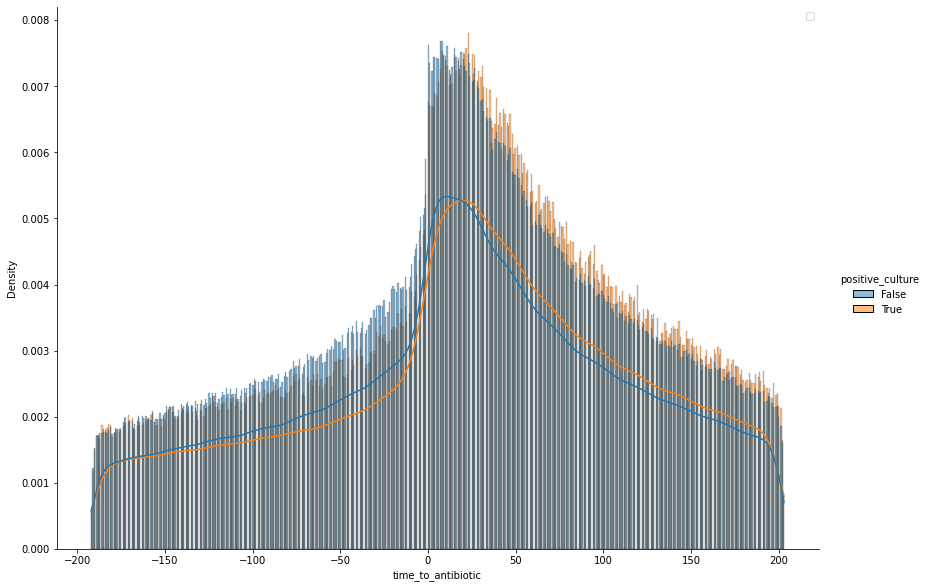

In [306]:
import seaborn as sns

sns.displot(timeToAntibioticDf12, x="time_to_antibiotic", hue="positive_culture", stat="density", bins=550, common_norm=False, kde=True, height=8.27, aspect=11.7/8.27)

plt.legend(loc='upper right')

Text(0, 0.5, 'Proportion')

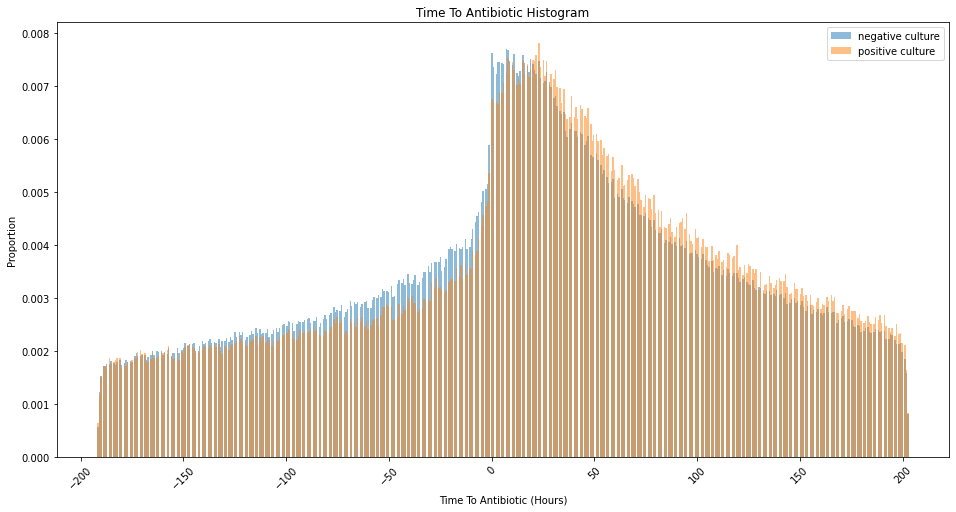

In [307]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation = 45)
plt.hist(timeToAntibioticDf12[timeToAntibioticDf12.positive_culture == False].time_to_antibiotic, density=True, bins=550, alpha=0.5, label='negative culture')
plt.hist(timeToAntibioticDf12[timeToAntibioticDf12.positive_culture == True].time_to_antibiotic, density=True, bins=550, alpha=0.5, label='positive culture')

plt.legend(loc='upper right')

ax.set_title('Time To Antibiotic Histogram')
ax.set_xlabel('Time To Antibiotic (Hours)')
ax.set_ylabel('Proportion')

## Time to Antibiotic - Changed antibiotic input - `S`, `I`, `R` Interpretations

In [309]:
timeToAntibioticQuery13 = """
with first_mic_evt as (
	select
	distinct
	first_value(mic_evt_1.subject_id) over (partition by mic_evt_1.micro_specimen_id) as subject_id,
	min(mic_evt_1.charttime) over (partition by mic_evt_1.micro_specimen_id) as charttime,
	mic_evt_1.interpretation AS interpretation
	from
	mimiciv.microbiologyevents mic_evt_1
)
, stg_2 as (
	select
	first_mic_evt.subject_id as subject_id,
	first_mic_evt.charttime as charttime,
	ipt.starttime as starttime,
	first_mic_evt.interpretation as interpretation
	from
	first_mic_evt first_mic_evt
	inner join mimiciv.inputevents ipt
	on ipt.subject_id = first_mic_evt.subject_id
	and ipt.starttime > first_mic_evt.charttime - interval '240 hours'
	and ipt.starttime < first_mic_evt.charttime + interval '240 hours'
	and exists (
		select
		1
		from mimiciv.inputevents ipt_inr
		where ipt_inr.subject_id = ipt.subject_id
		and ipt_inr.hadm_id = ipt.hadm_id
		and ipt_inr.itemid != ipt.itemid
        and ipt_inr.starttime > first_mic_evt.charttime - interval '192 hours'
        and ipt_inr.starttime < first_mic_evt.charttime + interval '192 hours'
		and ipt_inr.starttime < ipt.starttime
		and ipt_inr.starttime > ipt.starttime - interval '12 hours'
	)
	inner join mimiciv.d_items lkp
	on lkp.itemid = ipt.itemid and lkp.category = 'Antibiotics'
	group by first_mic_evt.subject_id, first_mic_evt.charttime, ipt.starttime, interpretation
)
select
floor((extract(epoch from stg_2.starttime) - extract(epoch from stg_2.charttime))/3600) as time_to_antibiotic,
interpretation
from stg_2 stg_2
;
"""
timeToAntibioticDf13 = pd.read_sql_query(timeToAntibioticQuery13, con)
timeToAntibioticDf13

,time_to_antibiotic,interpretation
0,3.0,None
1,4.0,None
2,-1.0,None
3,1.0,None
4,46.0,None
...,...,...
6006151,-6.0,None
6006152,-5.0,None
6006153,-4.0,None
6006154,-3.0,None


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


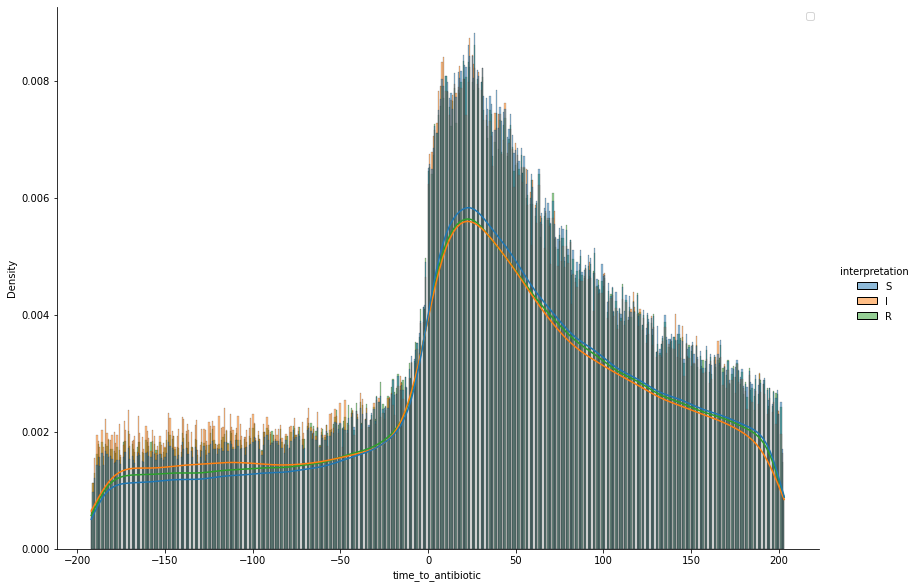

In [310]:
import seaborn as sns

sns.displot(timeToAntibioticDf13, x="time_to_antibiotic", hue="interpretation", stat="density", bins=550, common_norm=False, kde=True, height=8.27, aspect=11.7/8.27)

plt.legend(loc='upper right')

Text(0, 0.5, 'Proportion')

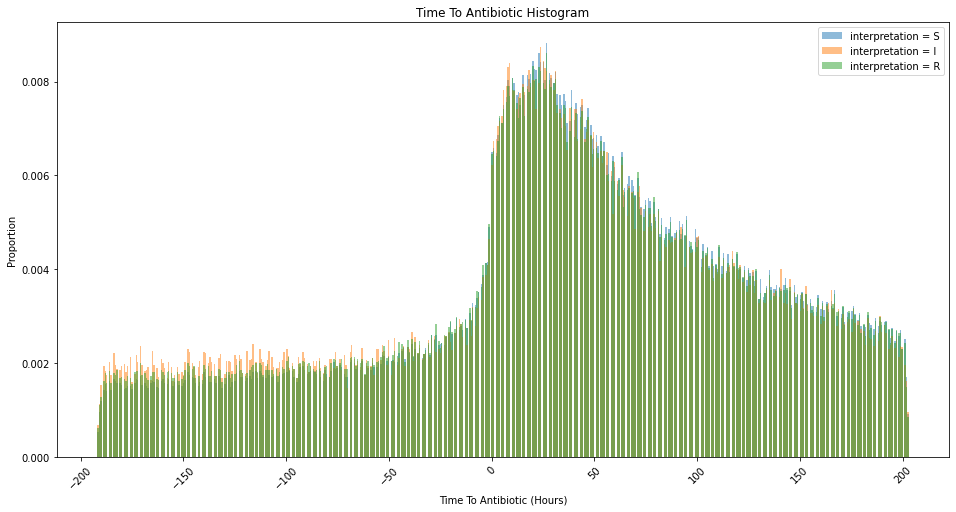

In [311]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation = 45)
plt.hist(timeToAntibioticDf13[timeToAntibioticDf13.interpretation == 'S'].time_to_antibiotic, density=True, bins=550, alpha=0.5, label='interpretation = S')
plt.hist(timeToAntibioticDf13[timeToAntibioticDf13.interpretation == 'I'].time_to_antibiotic, density=True, bins=550, alpha=0.5, label='interpretation = I')
plt.hist(timeToAntibioticDf13[timeToAntibioticDf13.interpretation == 'R'].time_to_antibiotic, density=True, bins=550, alpha=0.5, label='interpretation = R')

plt.legend(loc='upper right')

ax.set_title('Time To Antibiotic Histogram')
ax.set_xlabel('Time To Antibiotic (Hours)')
ax.set_ylabel('Proportion')

## AST breakpoints

In [347]:
breakpointsQuery = """
select
org_name, ab_name, dilution_text, dilution_comparison, dilution_value, interpretation, count(*)
from
mimiciv.microbiologyevents
where org_name = 'ESCHERICHIA COLI'
group by org_name, ab_name, dilution_text, dilution_comparison, dilution_value, interpretation
order by org_name, ab_name, interpretation
;
"""
breakpointsDf = pd.read_sql_query(breakpointsQuery, con)
breakpointsDf[breakpointsDf.ab_name == 'AMIKACIN']

,org_name,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation,count
0,ESCHERICHIA COLI,AMIKACIN,32,=,32.0,I,7
1,ESCHERICHIA COLI,AMIKACIN,<=2,<=,2.0,R,1
2,ESCHERICHIA COLI,AMIKACIN,=>64,=>,64.0,R,39
3,ESCHERICHIA COLI,AMIKACIN,16,=,16.0,S,219
4,ESCHERICHIA COLI,AMIKACIN,<=2,<=,2.0,S,2204
5,ESCHERICHIA COLI,AMIKACIN,4,=,4.0,S,387
6,ESCHERICHIA COLI,AMIKACIN,8,=,8.0,S,188
7,ESCHERICHIA COLI,AMIKACIN,None,None,NaN,S,7


In [348]:
breakpointsDf[breakpointsDf.ab_name == 'AMPICILLIN']

,org_name,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation,count
8,ESCHERICHIA COLI,AMPICILLIN,16,=,16.0,I,415
9,ESCHERICHIA COLI,AMPICILLIN,=>16,=>,16.0,R,11
10,ESCHERICHIA COLI,AMPICILLIN,16,=,16.0,R,9
11,ESCHERICHIA COLI,AMPICILLIN,=>256,=>,256.0,R,8
12,ESCHERICHIA COLI,AMPICILLIN,=>32,=>,32.0,R,18453
13,ESCHERICHIA COLI,AMPICILLIN,None,None,NaN,R,22
14,ESCHERICHIA COLI,AMPICILLIN,<=1,<=,1.0,S,1
15,ESCHERICHIA COLI,AMPICILLIN,16,=,16.0,S,1
16,ESCHERICHIA COLI,AMPICILLIN,<=2,<=,2.0,S,10332
17,ESCHERICHIA COLI,AMPICILLIN,=>32,=>,32.0,S,3


## Site of collection for top organisms

In [350]:
siteOfCollectionQuery = """
with t1 as (
	select
	spec_type_desc,
	org_name,
	count(*) as cnt,
	sum(case when (interpretation = 'S') then 1 else 0 end) as S_cnt,
	sum(case when (interpretation = 'I') then 1 else 0 end) as I_cnt,
	sum(case when (interpretation = 'R') then 1 else 0 end) as R_cnt
	from
	mimiciv.microbiologyevents
	where spec_type_desc = 'BLOOD CULTURE'
	group by spec_type_desc, org_name
	order by cnt desc
)
select
spec_type_desc,
org_name,
cnt,
S_cnt,
round(((S_cnt/cnt::float)*100)::numeric, 2) as S_pct,
I_cnt,
round(((I_cnt/cnt::float)*100)::numeric, 2) as I_pct,
R_cnt,
round(((R_cnt/cnt::float)*100)::numeric, 2) as R_pct
from
t1
;
"""
siteOfCollectionDf = pd.read_sql_query(siteOfCollectionQuery, con)
siteOfCollectionDf.head(20)

,spec_type_desc,org_name,cnt,s_cnt,s_pct,i_cnt,i_pct,r_cnt,r_pct
0,BLOOD CULTURE,None,508891,0,0.00,0,0.00,0,0.00
1,BLOOD CULTURE,CANCELLED,31061,0,0.00,0,0.00,0,0.00
2,BLOOD CULTURE,ESCHERICHIA COLI,30002,20925,69.75,891,2.97,6820,22.73
3,BLOOD CULTURE,STAPH AUREUS COAG +,21017,13156,62.60,33,0.16,4794,22.81
4,BLOOD CULTURE,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",17621,8453,47.97,159,0.90,5073,28.79
5,BLOOD CULTURE,STAPHYLOCOCCUS EPIDERMIDIS,9444,5465,57.87,158,1.67,3715,39.34
6,BLOOD CULTURE,KLEBSIELLA PNEUMONIAE,9034,7289,80.68,145,1.61,1096,12.13
7,BLOOD CULTURE,ENTEROCOCCUS FAECIUM,5074,1732,34.13,7,0.14,2362,46.55
8,BLOOD CULTURE,ENTEROCOCCUS FAECALIS,3212,2561,79.73,3,0.09,69,2.15
9,BLOOD CULTURE,PSEUDOMONAS AERUGINOSA,2514,1793,71.32,163,6.48,365,14.52
